# XClone tutorials on BCH869 scRNA-seq

A public glioma sample with histone H3 lysine27-to-methionine mutations (H3K27M-glioma), BCH869 dataset used in this tutorial is acquired from [Filbin et al. (2018)](https://www.science.org/doi/10.1126/science.aao4750).
The BCH869 data generated using **smart-seq2** was downloaded in FASTQ files from GEO [GSE102130](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE102130) by request from the authors. 
Within the original BCH869 dataset, there are 489 cells, with four tumor subclones composed of 227, 221, 34 and 7 cells, according to the original study, 3 normal cells (Oligodendrocytes and immune cells) from the same sample were combined in the dataset as reference cells in our study.

This dataset can be used to detect complex CNV clonal information in tumor sample.
According to the original paper's annotations, the term "Clone_ID" in the `anndata` is used to indicate the specific clone to which the cells belong.

Download the Jupyter Notebook by clicking on the [Download BCH869 scRNA-seq demo Notebook](https://github.com/Rongtingting/xclone-data/blob/main/examples/BCH869_XClone_tutorials.ipynb).


## Introduction
This tutorial covers how to use XClone for scRNA-seq CNV analysis in RDR module, BAF module and Combine module independently.

Author: [Rongting Huang](rthuang@connect.hku.hk)

Date: 2023-04-03

The data used in this tutorial is available in XClone package and can be download from [xclonedata](https://github.com/Rongtingting/xclone-data/tree/main/BCH869_scRNA).

The data contains:

- Single-cell RNA-seq read count data for XClone RDR module and BAF module.


Requirements

To follow this tutorial, you will need:

- Python 3.7.

- The following Python packages: XClone and its dependent packages, e.g., anndata, numpy, scipy, pandas, scanpy.

In this tutorial, we covered how to use XClone for scRNA CNV analysis. If you have any questions or comments, please feel free to contact the author.

## Load packages

In [1]:
%load_ext autoreload
%autoreload 2

import xclone
import anndata as an
import pandas as pd
import numpy as np
import scipy
print("scipy", scipy.__version__)

xclone.pp.efficiency_preview()

(Running XClone 0.3.4)
2023-04-03 09:56:58
scipy 1.7.0
[XClone efficiency] multiprocessing cpu total count in your device 112


In [2]:
dataset_name = "BCH869_scRNA"
## output results dir
outdir = "/storage/xxxx/users/xxxx/xclone/tutorials/"

To specify the name of your dataset and the output directory where the results will be saved, you can set the `dataset_name` and `outdir` parameters before you start using any module in XClone.
Replace "BCH869_scRNA" with a name of your choice to identify your dataset, and `"/storage/xxxx/users/xxxx/xclone/tutorials/"` with the path to the directory where you want to save the output files.

## Load dataset

For BCH869 dataset, users can easily load the raw read count matrices for RDR module and BAF module, respectively by `xclone.data.bch869_rdr()` and `xclone.data.bch869_baf()`.

Users can load the matricesin  anndata object in Python, it typically contains several matrices or tables of data, each with its own set of row and/or column annotations. 
The obs attribute typically contains annotation information for each cell in the dataset, and the var attribute typically contains annotation information for each gene in the dataset. 

obs attribute used in `XClone`:

`Clone_ID`: Clone identifier for each cell from the original paper.

`cell_type`: Normal and tumor cells, `'N'` and `'T'` here in BCH869 dataset.

Additional cell-level annotations can be merged in `obs` by users.

var attribute used in `XClone`:

`GeneName`: Gene Names for each gene in the dataset.

`GeneID`: Identifier or accession number of each gene in the dataset(if available).

`chr`: Chromosome location of each gene.

`start`: Start position of each gene on its chromosome.

`stop`: End position of each gene on its chromosome.

`arm`: Chromosome arm information for each gene.

`chr_arm`: Combined Chromosome and arm information for  each gene.

`band`: Chromosome band information for each gene (if available)..

Additional gene-level annotations can be merged in `var` by users.

For RDR module, there is `raw_expr` layer in the anndata, and for BAF module,  there are two layers `AD` and `DP`, initially.


In [3]:
RDR_adata = xclone.data.bch869_rdr()

In [4]:
BAF_adata = xclone.data.bch869_baf()

In [5]:
RDR_adata
RDR_adata.uns["data_notes"]

AnnData object with n_obs × n_vars = 492 × 32696
    obs: 'Sample', 'GenesExpressed', 'HousekeepingGeneExpression', 'Type', 'Cellcycle', 'OPC-variable', 'OC-like', 'AC-like', 'OPC-like', 'Clone_ID', 'cell_type'
    var: 'GeneName', 'GeneID', 'chr', 'start', 'stop', 'arm', 'chr_arm', 'band'
    uns: 'data_mode', 'data_notes', 'genome_mode', 'log'
    layers: 'raw_expr'

'2022-11-07 14:10:33'

In [6]:
BAF_adata
BAF_adata.uns["data_notes"]

AnnData object with n_obs × n_vars = 492 × 32696
    obs: 'Sample', 'GenesExpressed', 'HousekeepingGeneExpression', 'Type', 'Cellcycle', 'OPC-variable', 'OC-like', 'AC-like', 'OPC-like', 'Clone_ID', 'cell_type'
    var: 'GeneName', 'GeneID', 'chr', 'start', 'stop', 'arm', 'chr_arm', 'band'
    uns: 'data_mode', 'data_notes', 'genome_mode', 'log'
    layers: 'AD', 'DP'

'2022-10-21 15:05:42'

## RDR module

By calling the config method `xclone.XCloneConfig()`, users can create an instance of the `XCloneConfig` class in the `module` of "RDR" to set data-specific configures for RDR module.
It is default for 10x scRNA-seq data, if the datastet to be analysed is smart-seq, users need set True for `set_smartseq`.

In RDR module, specify a `cell_anno_key` with a cell annotation key used in your dataset, and `ref_celltype` as the reference cell type.

Set the output directory by specifying `outdir`.

XClone can defaultly detect and remove celltype-specific marker genes when users specify cell annotation key for `marker_group_anno_key` and N top marker genes in each cell group to be removed by specify the number in  `top_n_marker`, $N=15$ by default. However users can set more, e.g., $N = 25$ if the cell clusters are less. For example, there are only 2 cell type in selected annotation, `N` and `T` here in BCH869 dataset, and the majority of the cells are labeled `T`.

Users can decide to plot the main figures in each module or not by setting `xclone_plot`, True or False. If True, can also select cell annotation term `plot_cell_anno_key` for plotting cells by clusters.

XClone has default start probability for `start_prob` ([0.3, 0.4, 0.3] for copy loss, copy neutral and copy gain) in smart-seq dataset.

Before running the RDR moudle, users can use `xconfig.display()` to print all configurations used in RDR module for previewing and logging.

Users can run the analysis on your input data by calling the `run_RDR` method by specifying the `RDR_adata` and `config_file`. 
If no custmoised config file is used, XClone will load the default config file.

Here shows the example of BCH869 RDR module.

RDR 
Configurations:
HMM_brk                        chr_arm
KNN_neighbors                  10
WMA_smooth_key                 chr_arm
WMA_window_size                40
_file_format_data              h5ad
_file_format_figs              pdf
_frameon                       True
_outdir                        /storage/yhhuang/users/rthuang/xclone/tutorials
_plot_suffix                   
_start                         1680515845.0635133
_vector_friendly               True
cell_anno_key                  cell_type
dataset_name                   BCH869_scRNA
dispersion_celltype            None
exclude_XY                     True
file_format_data               h5ad
file_format_figs               pdf
filter_ref_ave                 1.8
fit_GLM_libratio               False
gene_exp_group                 1
gene_exp_ref_log               True
guide_chr_anno_key             chr_arm
guide_cnv_ratio                None
guide_qt_lst                   [0.0001, 0.96, 0.99]
marker_group_anno_key          ce

Trying to set attribute `.var` of view, copying.


[XClone] use marker genes provided by users: 
 ['AC020594.5' 'AFF3' 'AKT3' 'ATF3' 'CTD-2370N5.3' 'DGKI' 'DPP6' 'ELL2'
 'ENAH' 'ENPP2' 'EVI2A' 'GSN' 'GSN-AS1' 'ILF3' 'JPH1' 'KCNJ2' 'LPCAT2'
 'MAP2' 'MARCKS' 'MDM4' 'MSTO1' 'NFIB' 'NINJ2' 'NRXN1' 'PCBP1-AS1'
 'PCDHGA1' 'PCDHGA2' 'PCDHGA3' 'PCDHGA4' 'PCDHGA5' 'PCDHGB1' 'PCDHGB2'
 'RAPGEF3' 'RFWD2' 'RP1-197B17.3' 'RP11-108K3.1' 'RP11-218M22.1'
 'RP11-477J21.6' 'SFMBT2' 'SH3D21' 'SLC31A2' 'SPP1' 'SYNGR2' 'SYT11'
 'TGFA' 'TLR1' 'TNFAIP8L3' 'TNR' 'USP34' 'ZBTB20']
filter_genes_num: 50
used_genes_num: 5236
output anndata is not sparse matrix.


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


[XClone RDR gene dispersion fitting] Time used: 85 seconds
[XClone RDR gene-specific dispersion]: checking
max_value: 6.3557562680144075
min_value: 8.875568624874978e-08
qt_0.95_value: 4.108871386621837
qt_0.05_value: 6.533122476556893e-07
remove no GLM results genes num: 0
remove inf dispersion genes num: 0
[XClone RDR dispersion]: clipping
[XClone RDR gene-specific dispersion]: checking
max_value: 1.2666903869761477
min_value: 5.204269772930633e-07
qt_0.95_value: 1.2666903869761477
qt_0.05_value: 6.533122476556893e-07
[XClone hint] RDR_base_file and bulk_file saved in /storage/yhhuang/users/rthuang/xclone/tutorials/data/.
make WMA connectivities matrix, saved in varp[WMA_connect].
[XClone] RDR CNV states chrs guiding(copy loss, copy neutral, copy gain): ['14q', '10q', '1q']
CNV loss:  0.5521135627178742
CNV neutral:  1.03045382669756
CNV gain:  1.5131455671638907
[XClone] RDR CNV states ratio guiding(copy loss, copy neutral, copy gain): [0.55211356 1.03045383 1.51314557]
expression_b

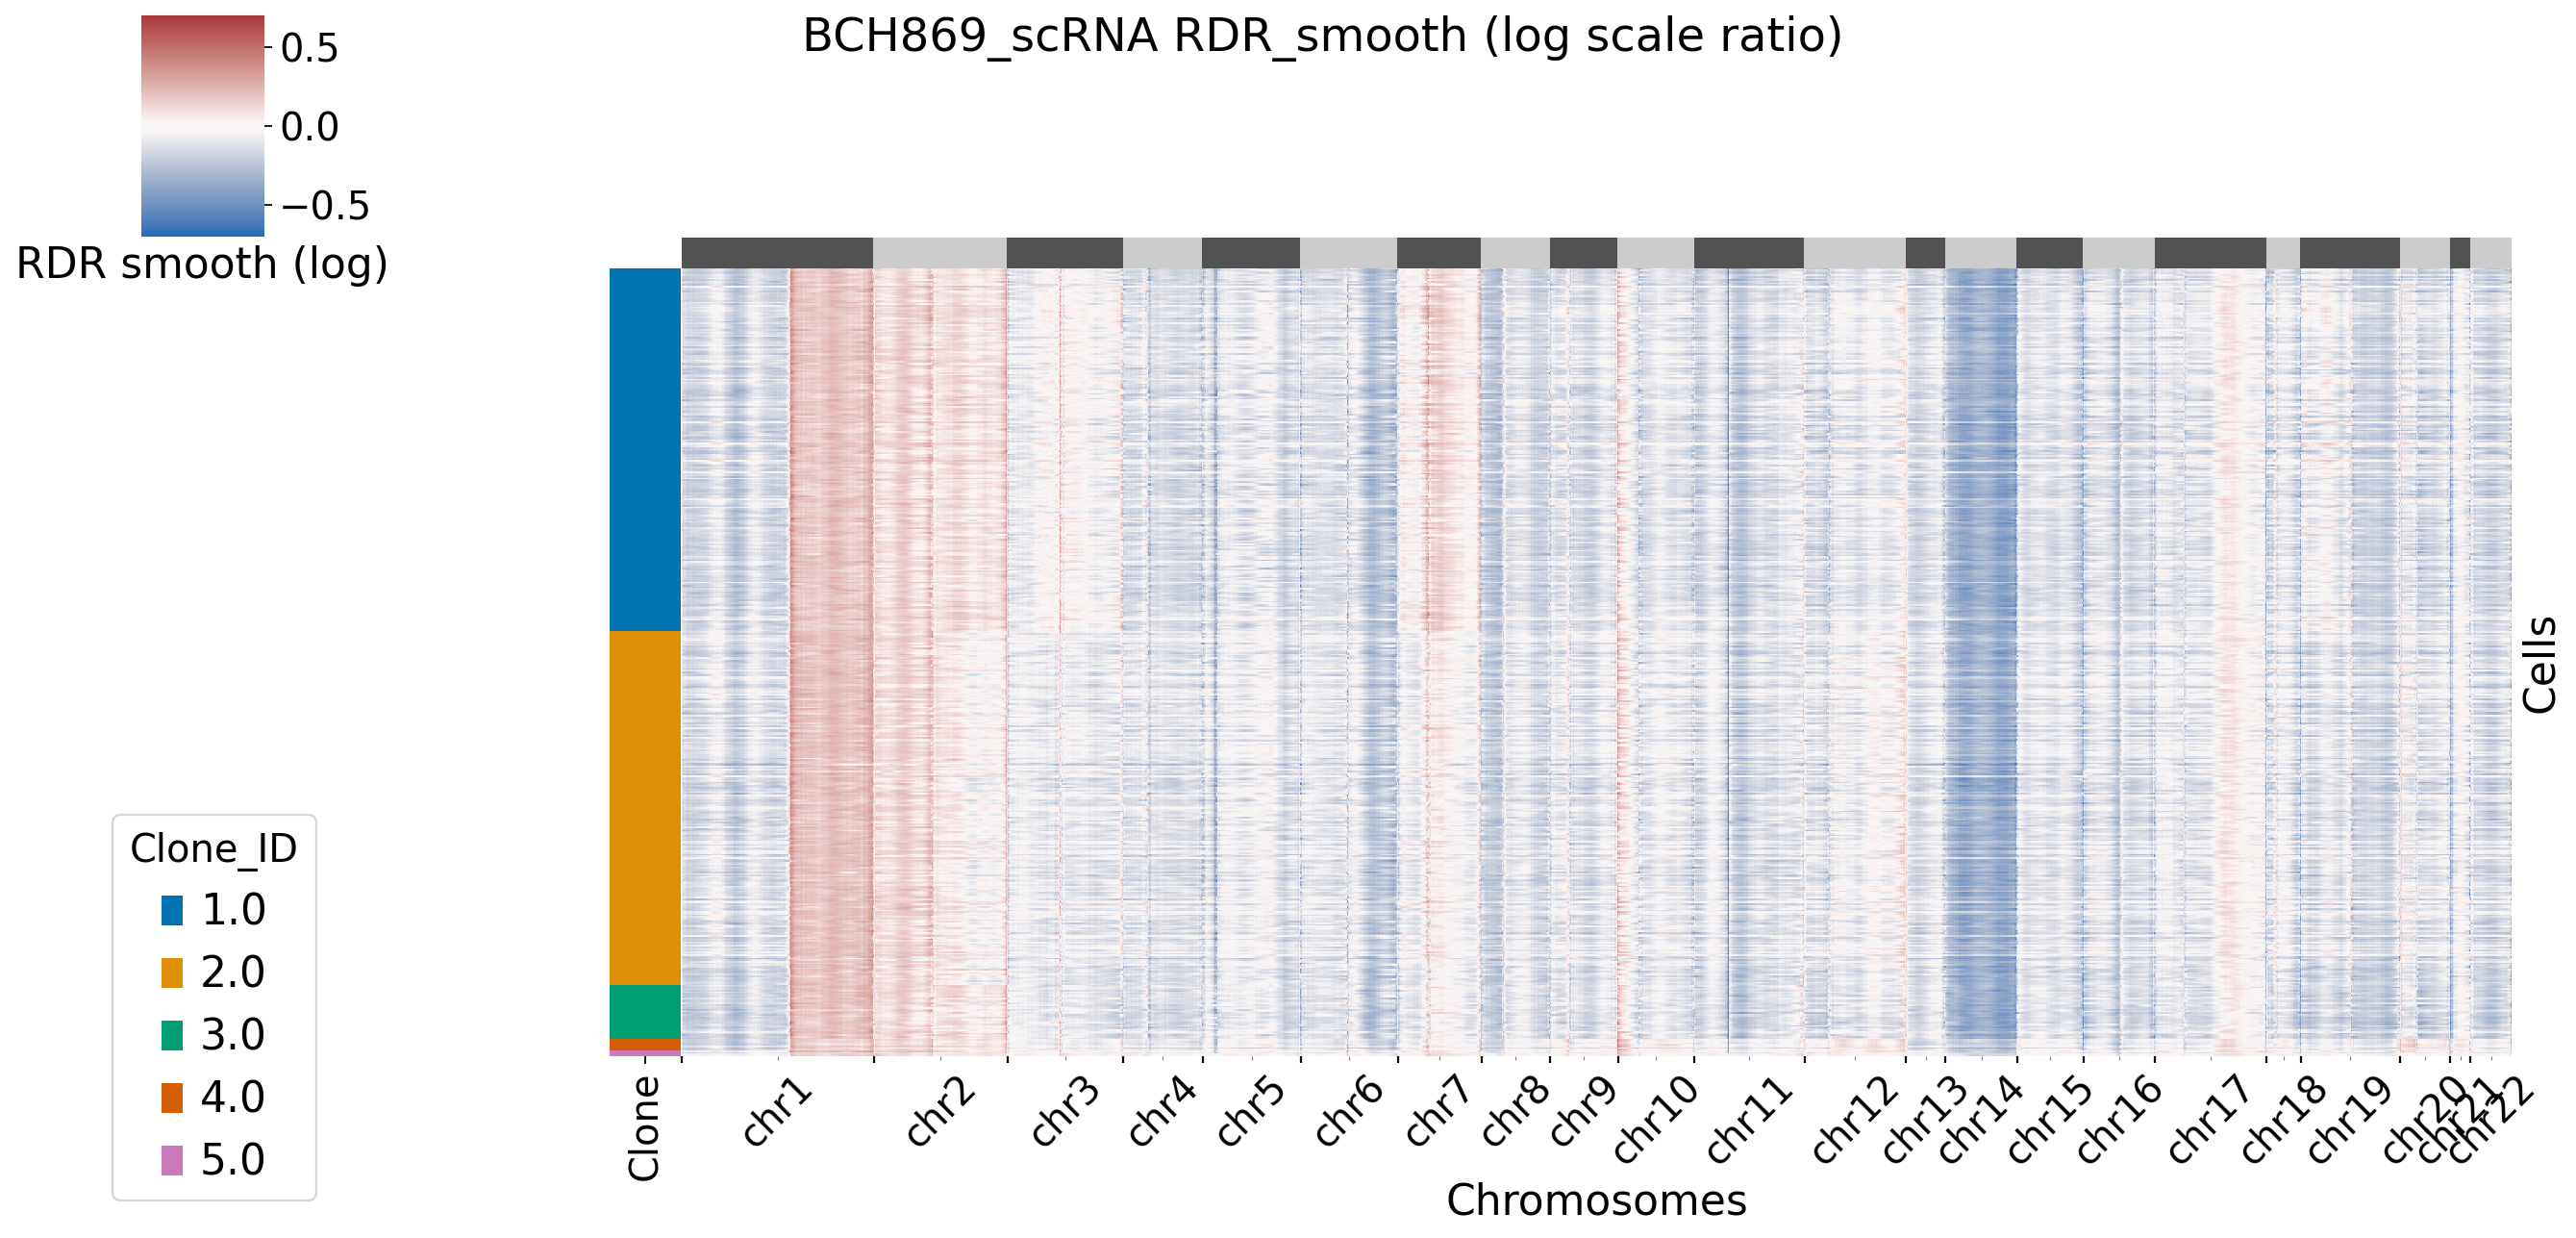

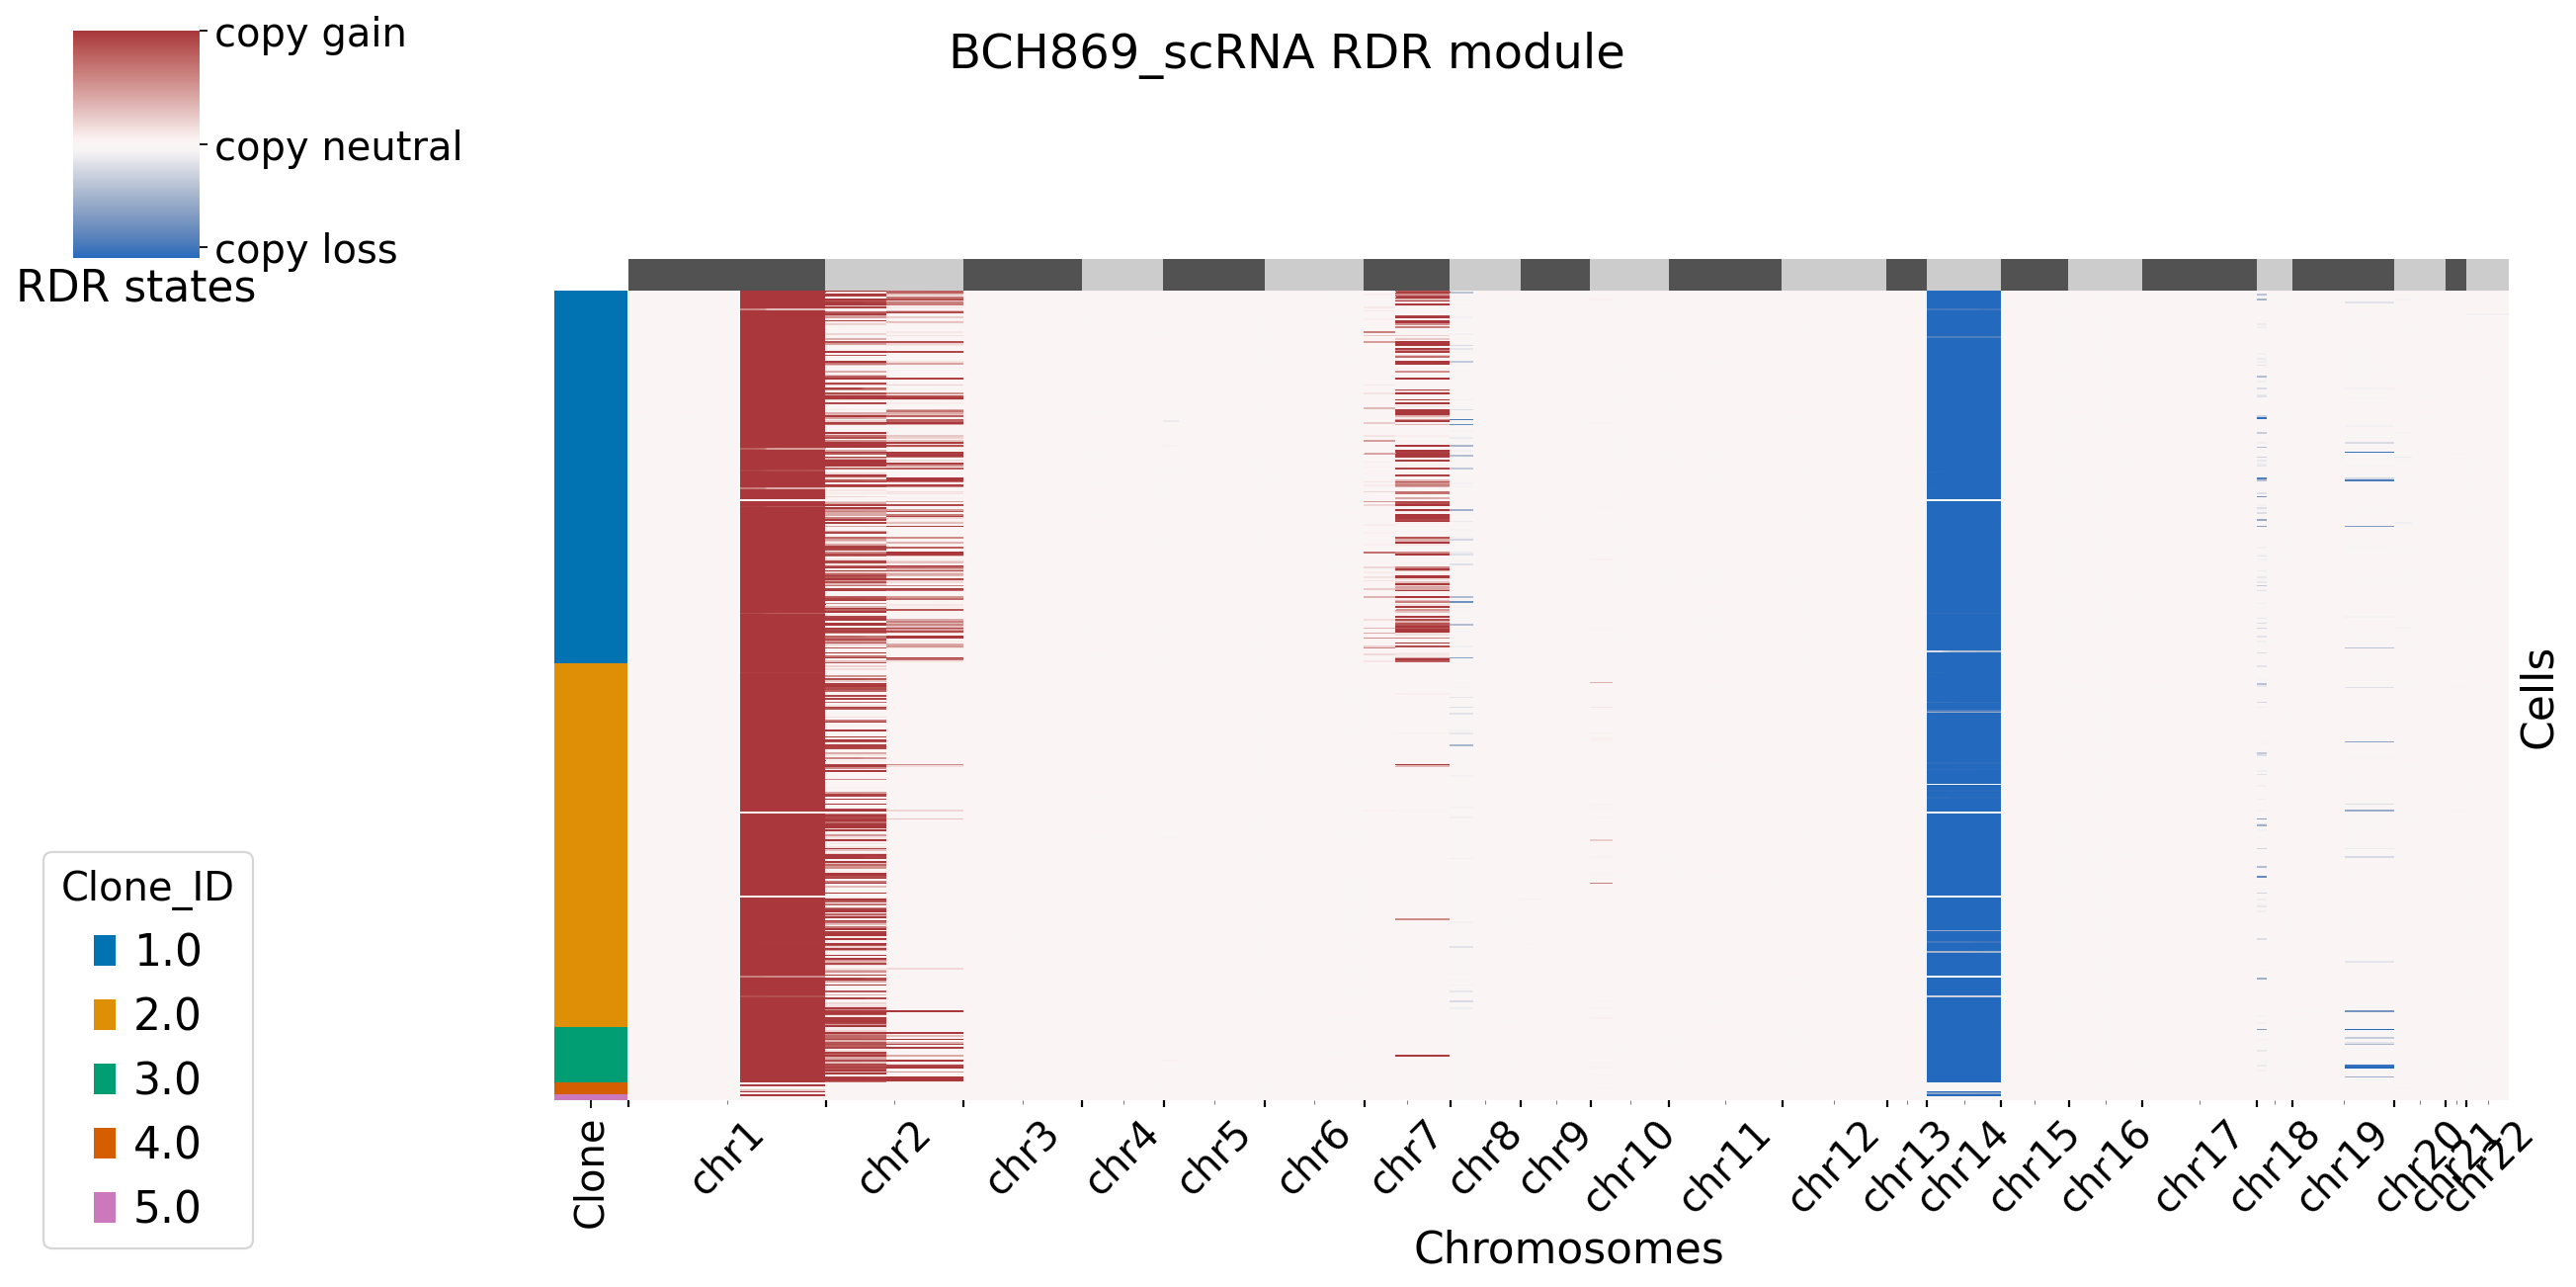

In [7]:
xconfig = xclone.XCloneConfig(dataset_name = dataset_name, module = "RDR", set_smartseq = True)
xconfig.set_figure_params(xclone= True, fontsize = 18)
xconfig.outdir = outdir
xconfig.cell_anno_key = "cell_type"
xconfig.ref_celltype = "N"
xconfig.top_n_marker = 25
xconfig.marker_group_anno_key = "cell_type"
xconfig.xclone_plot= True
xconfig.plot_cell_anno_key = "Clone_ID"
xconfig.display()

RDR_Xdata = xclone.model.run_RDR(RDR_adata,
            config_file = xconfig)

In [8]:
RDR_Xdata

AnnData object with n_obs × n_vars = 492 × 5235
    obs: 'Sample', 'GenesExpressed', 'HousekeepingGeneExpression', 'Type', 'Cellcycle', 'OPC-variable', 'OC-like', 'AC-like', 'OPC-like', 'Clone_ID', 'cell_type', 'counts_ratio'
    var: 'GeneName', 'GeneID', 'chr', 'start', 'stop', 'arm', 'chr_arm', 'band', 'ref_avg', 'dispersion', 'gene_dispersion_bse', 'dispersion_capped'
    uns: 'data_mode', 'data_notes', 'genome_mode', 'log', 'rank_marker_genes', 'fit_dispersion_removed_genes', 'dispersion_base_celltype', 'pca', 'neighbors', 'chr_dict', 'guide_CNV_chrs_use_layers', 'guide_CNV_chrs_use_anno_key', 'ref_log_expression_brk', 'group_genes', 'CNV_ratio', 'Logliklihood'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_expr', 'raw_ratio', 'ref_normalized', 'expected', 'WMA_smoothed', 'RDR_smooth', 'emm_prob_log', 'emm_prob_log_noHMM', 'emm_prob_noHMM', 'posterior_mtx', 'posterior_mtx_log'
    obsp: 'distances', 'connectivities'

In [9]:
RDR_Xdata.layers["posterior_mtx"].shape

(492, 5235, 3)

In [10]:
RDR_Xdata.layers["posterior_mtx"].argmax(axis=-1).shape

(492, 5235)

Users can load the step by step results(AnnData) stored in `outdir/data`.

For the final RDR module CNV detection results, load the AnnData object results into memory:

```python
import anndata
filename = outdir+"data/RDR_adata_KNN_HMM_post.h5ad"
adata = anndata.read_h5ad(filename)
```

Access the posterior_mtx layer:
```python
cnv_prob = adata.layers["posterior_mtx"]
```
This will extract the final CNV calling results as a NumPy array.

The posterior_mtx layer contains the posterior probabilities of each cell  at each genomic segment(gene scale default) having each copy number state. 
The rows correspond to cells and the columns correspond to genomic segments.

```python
copy_states = cnv_prob.argmax(axis=-1)
```
This will give you a 2D numpy array hard assigned CNV states for each cell each gene.

For more to explore the results of XClone, pls refer to [link](link).

## BAF module

Similarly, by calling the config method `xclone.XCloneConfig()`, users can create an instance of the `XCloneConfig` class in the `module` of "BAF" to set data-specific configures for BAF module.
It is also default for 10x scRNA-seq data, if the datastet to be analysed is smart-seq, users need set True for `set_smartseq`.

It is default set `baf_bias_mode=1`, which supports $K=5$ BAF states: allele A bias (++), allele A bias (+), allele balance, allele B bias (+), and allele B bias (++). XClone provides $K=3$ BAF states for comparasion (visualization). In this mode, `CNV_N_components` is 5.
Alternatively, users can specify another mode by setting `baf_bias_mode=0`, which supports $K=3$ BAF states: allele A bias,allele balance, allele B bias.  In this mode, `CNV_N_components` is 3.

In BAF module, the start probability`start_prob` is default set as  $[0.3, 0.4, 0.3]$ and $[0.2,  0.15, 0.3,  0.15, 0.2]$ for $K=3$ and $K=5$, respectively. And the transition probability `trans_prob` for HMM smoothing is default set as $\{t = 1e-6$, $1-(K-1)t\}$ respectively for cross-state transition and state keeping.
If users change  `CNV_N_components` manually, should also consider the correspoding start probability and transition probability in HMM settings.

Generaly, users need specify a `cell_anno_key` with a cell annotation key used in your dataset, and `ref_celltype` as the reference cell type.

Set the output directory by specifying `outdir`.

Generaly, data-specific theoractical B allele frequency is fitted from the reference cells. However, if the reference cells is limited, users can set `theo_neutral_BAF=0.5` directly. For example, there are just 3 reference cells in BCH869 dataset, we set the `theo_neutral_BAF` directly to avoid high bias from the reference cells.

Users can decide to plot the main figures in each module or not by setting `xclone_plot`, True or False. If True, can also select cell annotation term `plot_cell_anno_key` for plotting cells by clusters. XClone perform the denoise strategy in BAF module and plot the denoised BAF CNV profile by default.

Before running the BAF moudle, users can use `xconfig.display()` to print all configurations used in RDR module for previewing and logging.

Users can run the analysis on your input data by calling the `run_BAF` method by specifying the `BAF_adata` and `config_file`. 
If no custmoised config file is used, XClone will load the default config file.

Here shows the example of BCH869 BAF module.

BAF 
Configurations:
BAF_add                        None
BAF_denoise                    True
BAF_denoise_GMM_comp           2
BAF_denoise_GMM_detection      True
BAF_denoise_cellprop_cutoff    0.05
CNV_N_components               5
HMM_brk                        chr_arm
KNN_neighbors                  10
RDR_file                       None
WMA_smooth_key                 chr_arm
WMA_window_size                6
_file_format_data              h5ad
_file_format_figs              pdf
_frameon                       True
_outdir                        /storage/yhhuang/users/rthuang/xclone/tutorials
_plot_suffix                   
_start                         1680516163.165731
_vector_friendly               True
baf_bias_mode                  1
bin_nproc                      20
cell_anno_key                  cell_type
concentration                  None
concentration_lower            20
concentration_upper            100
dataset_name                   BCH869_scRNA
exclude_XY                  

... storing 'bin_stop_arm' as categorical
... storing 'bin_stop_chr_arm' as categorical
... storing 'bin_stop_band' as categorical


[XClone hint] BAF_base_file and merged_file saved in /storage/yhhuang/users/rthuang/xclone/tutorials/data/.
[XClone get_CNV_states] time_used: 147.43seconds
states used: [0.23157682 0.38026897 0.5        0.6307046  0.81142831]
.....
[XClone] specific Center states used.
[XClone hint] specific concentrations used.
[XClone]: validated probability, all finite.
cal emm prob time 1 seconds
normalize the input emm_prob_log
normalized emm_prob_log
generate new layer key value: bin_phased_BAF_specific_center_emm_prob_log_KNN
[BAF smoothing] time_used: 1.33seconds
Cell level: no filtering emm_prob
Gene level: no filtering emm_prob
[XClone] multiprocessing for each brk item
nproc: 80
[XClone HMM smoothing] Time used: 9 seconds
[XClone get_CNV_states] time_used: 62.55seconds
states used: [0.27436964 0.5        0.72000833]
.....
[XClone] specific Center states used.
[XClone hint] specific concentrations used.
[XClone]: validated probability, all finite.
cal emm prob time 0 seconds
normalize the in

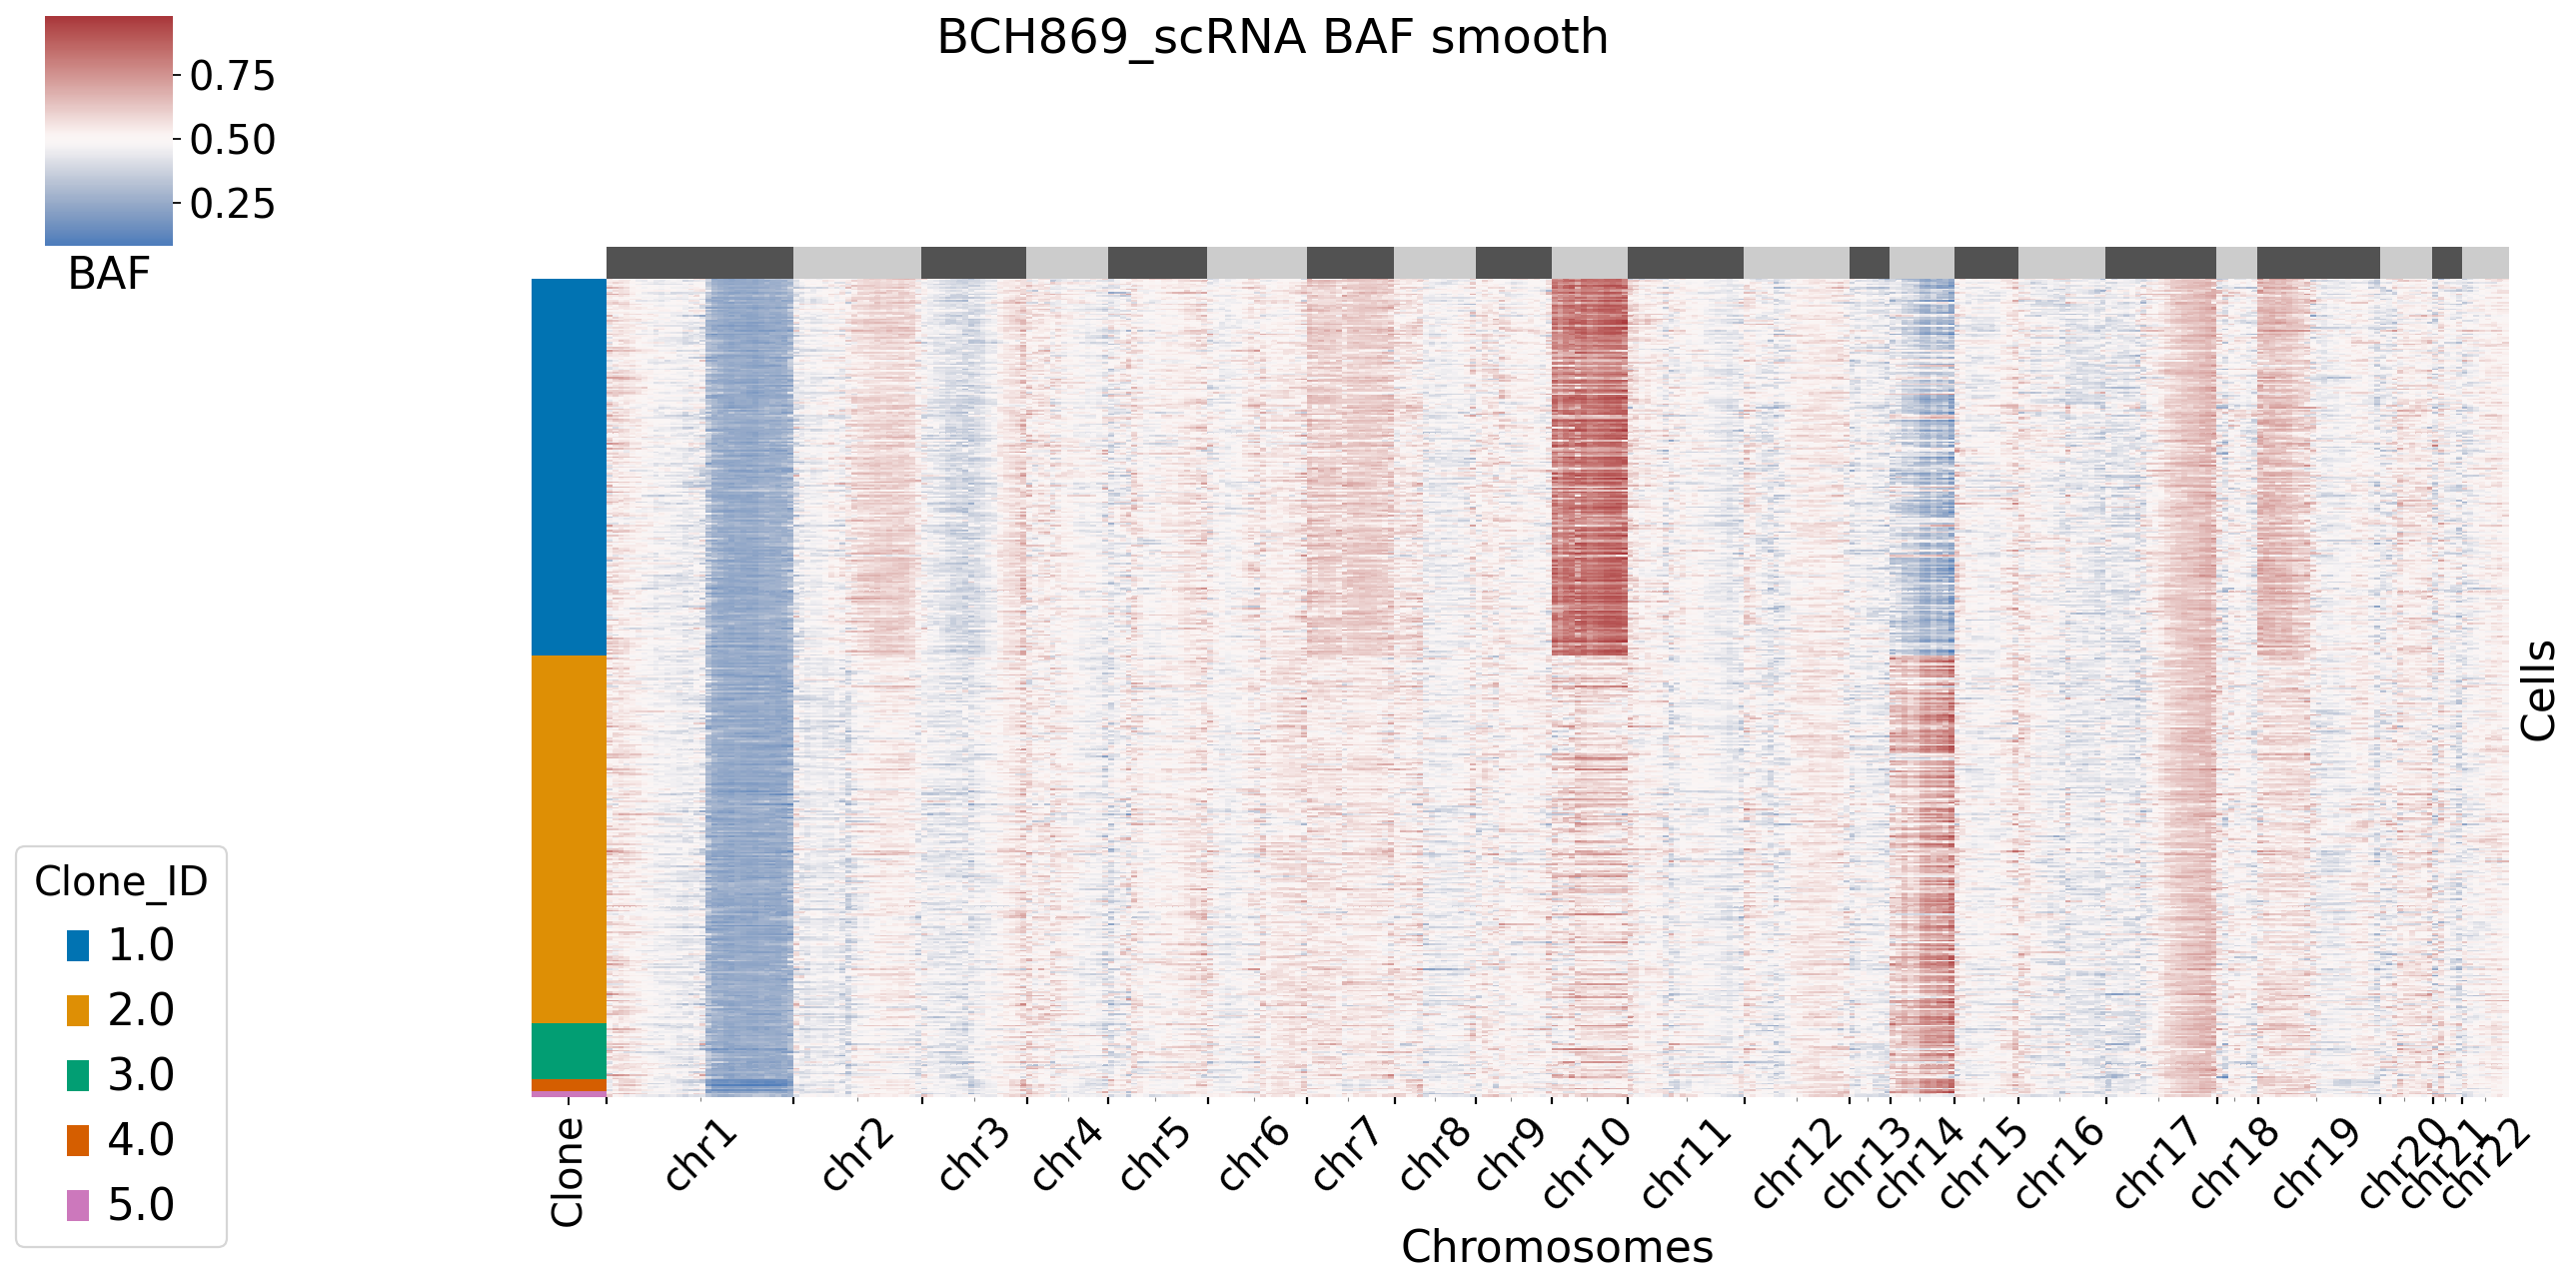

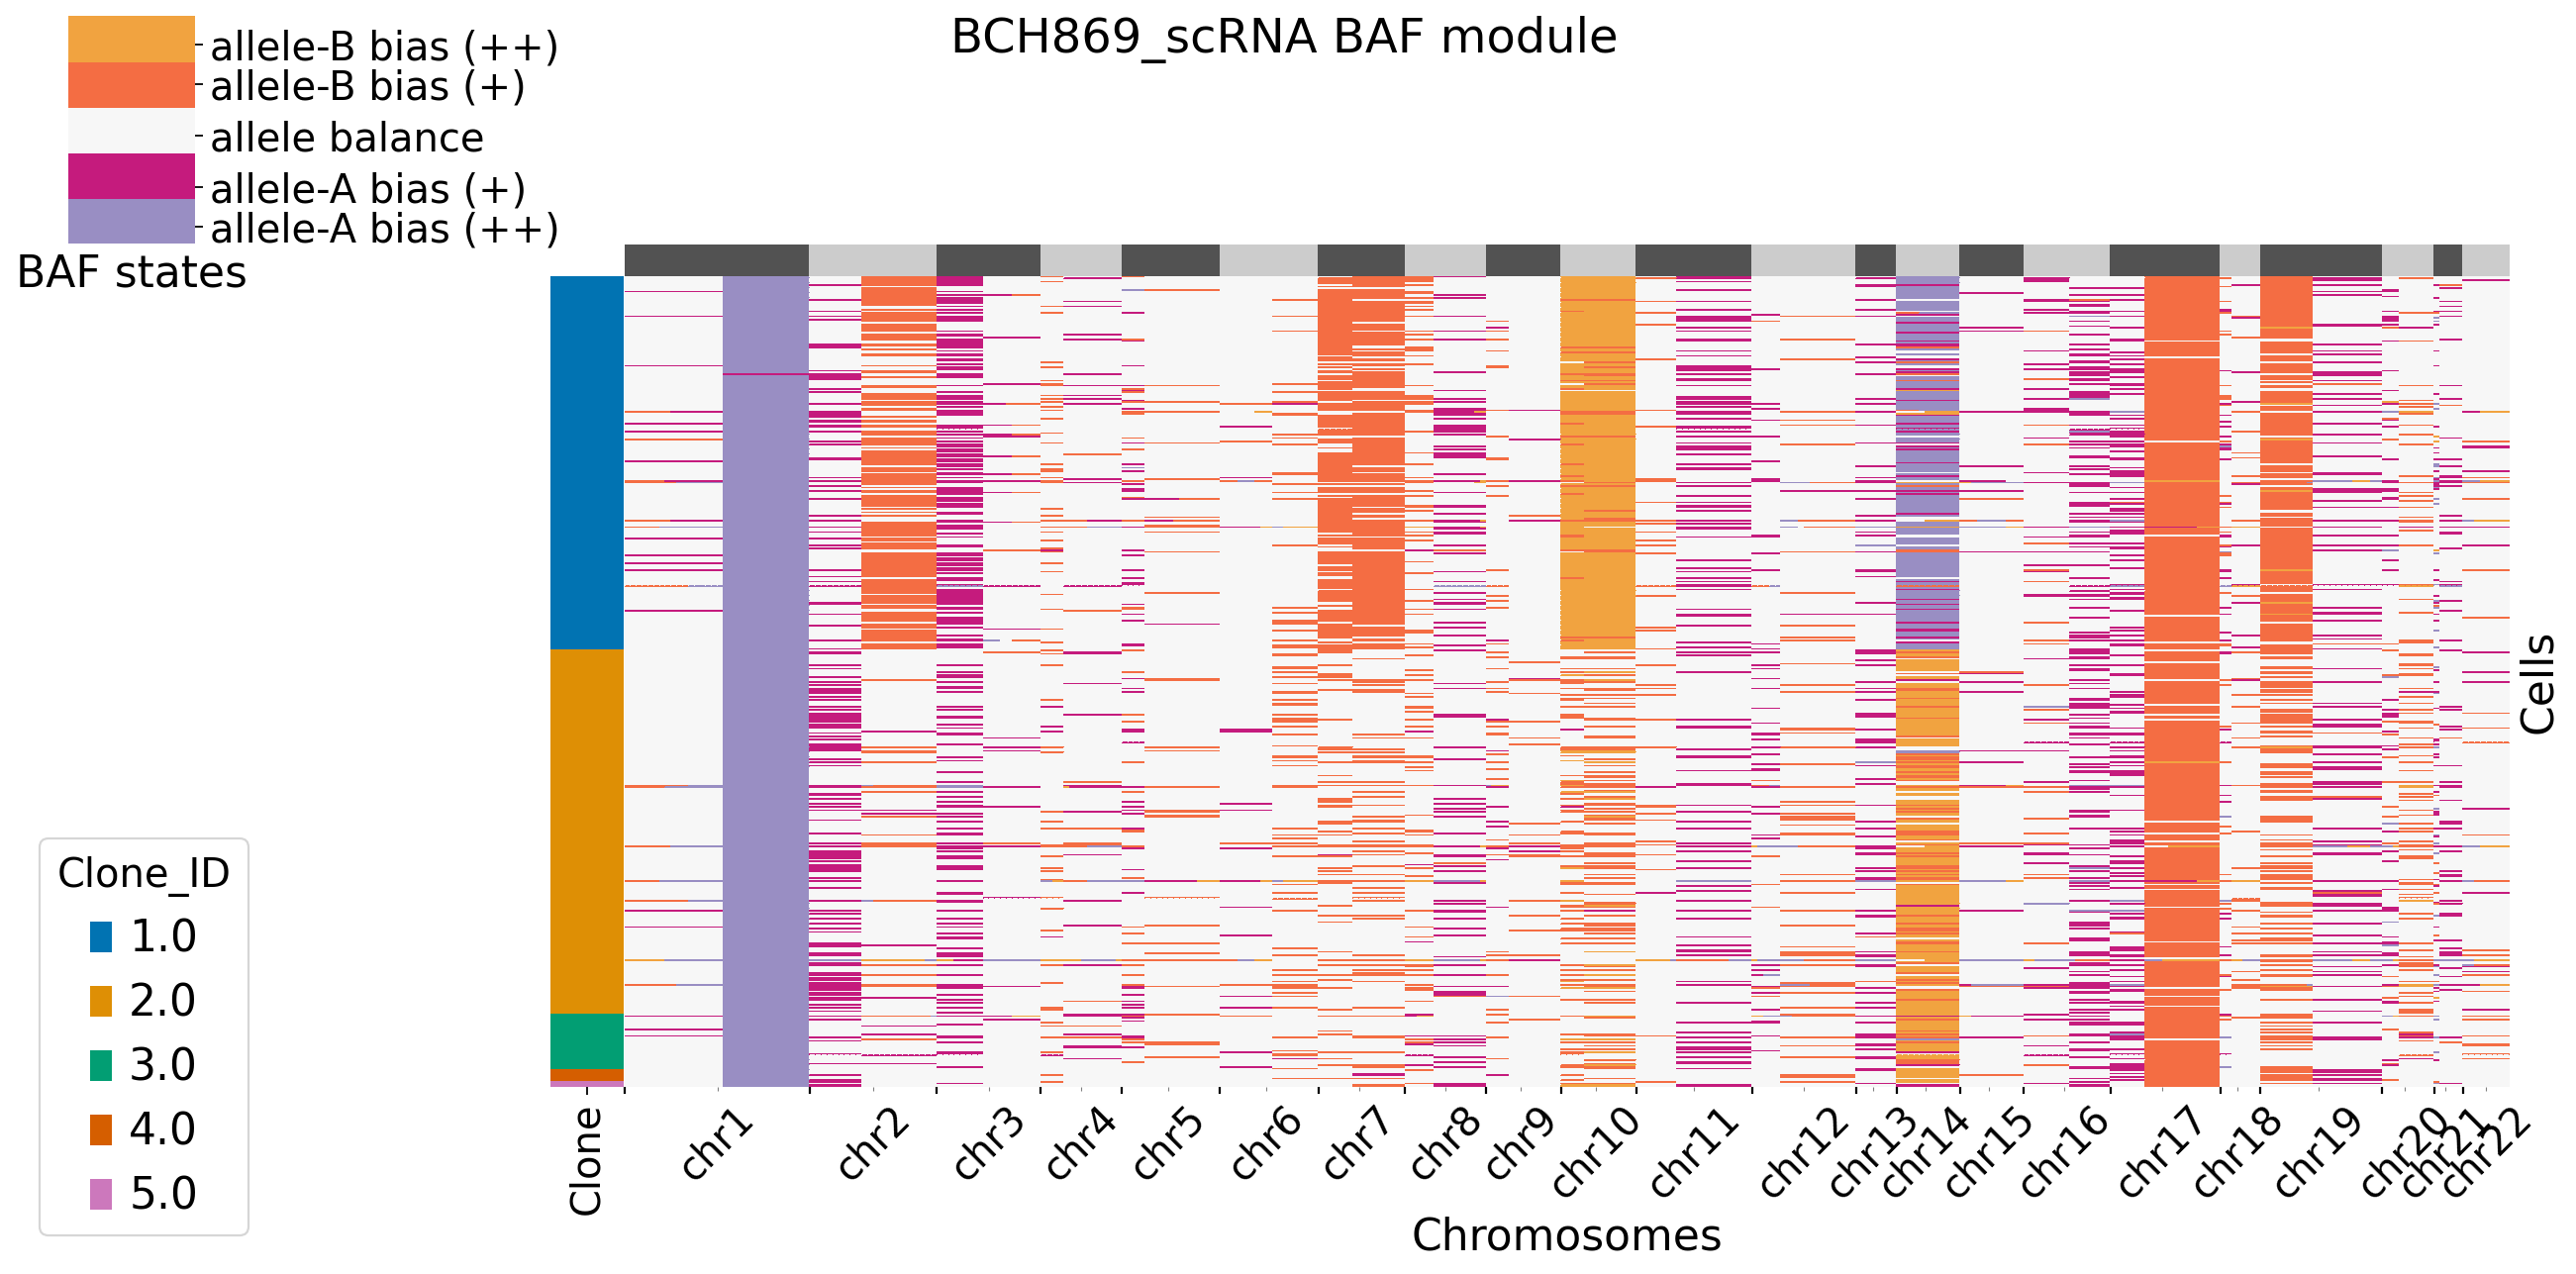

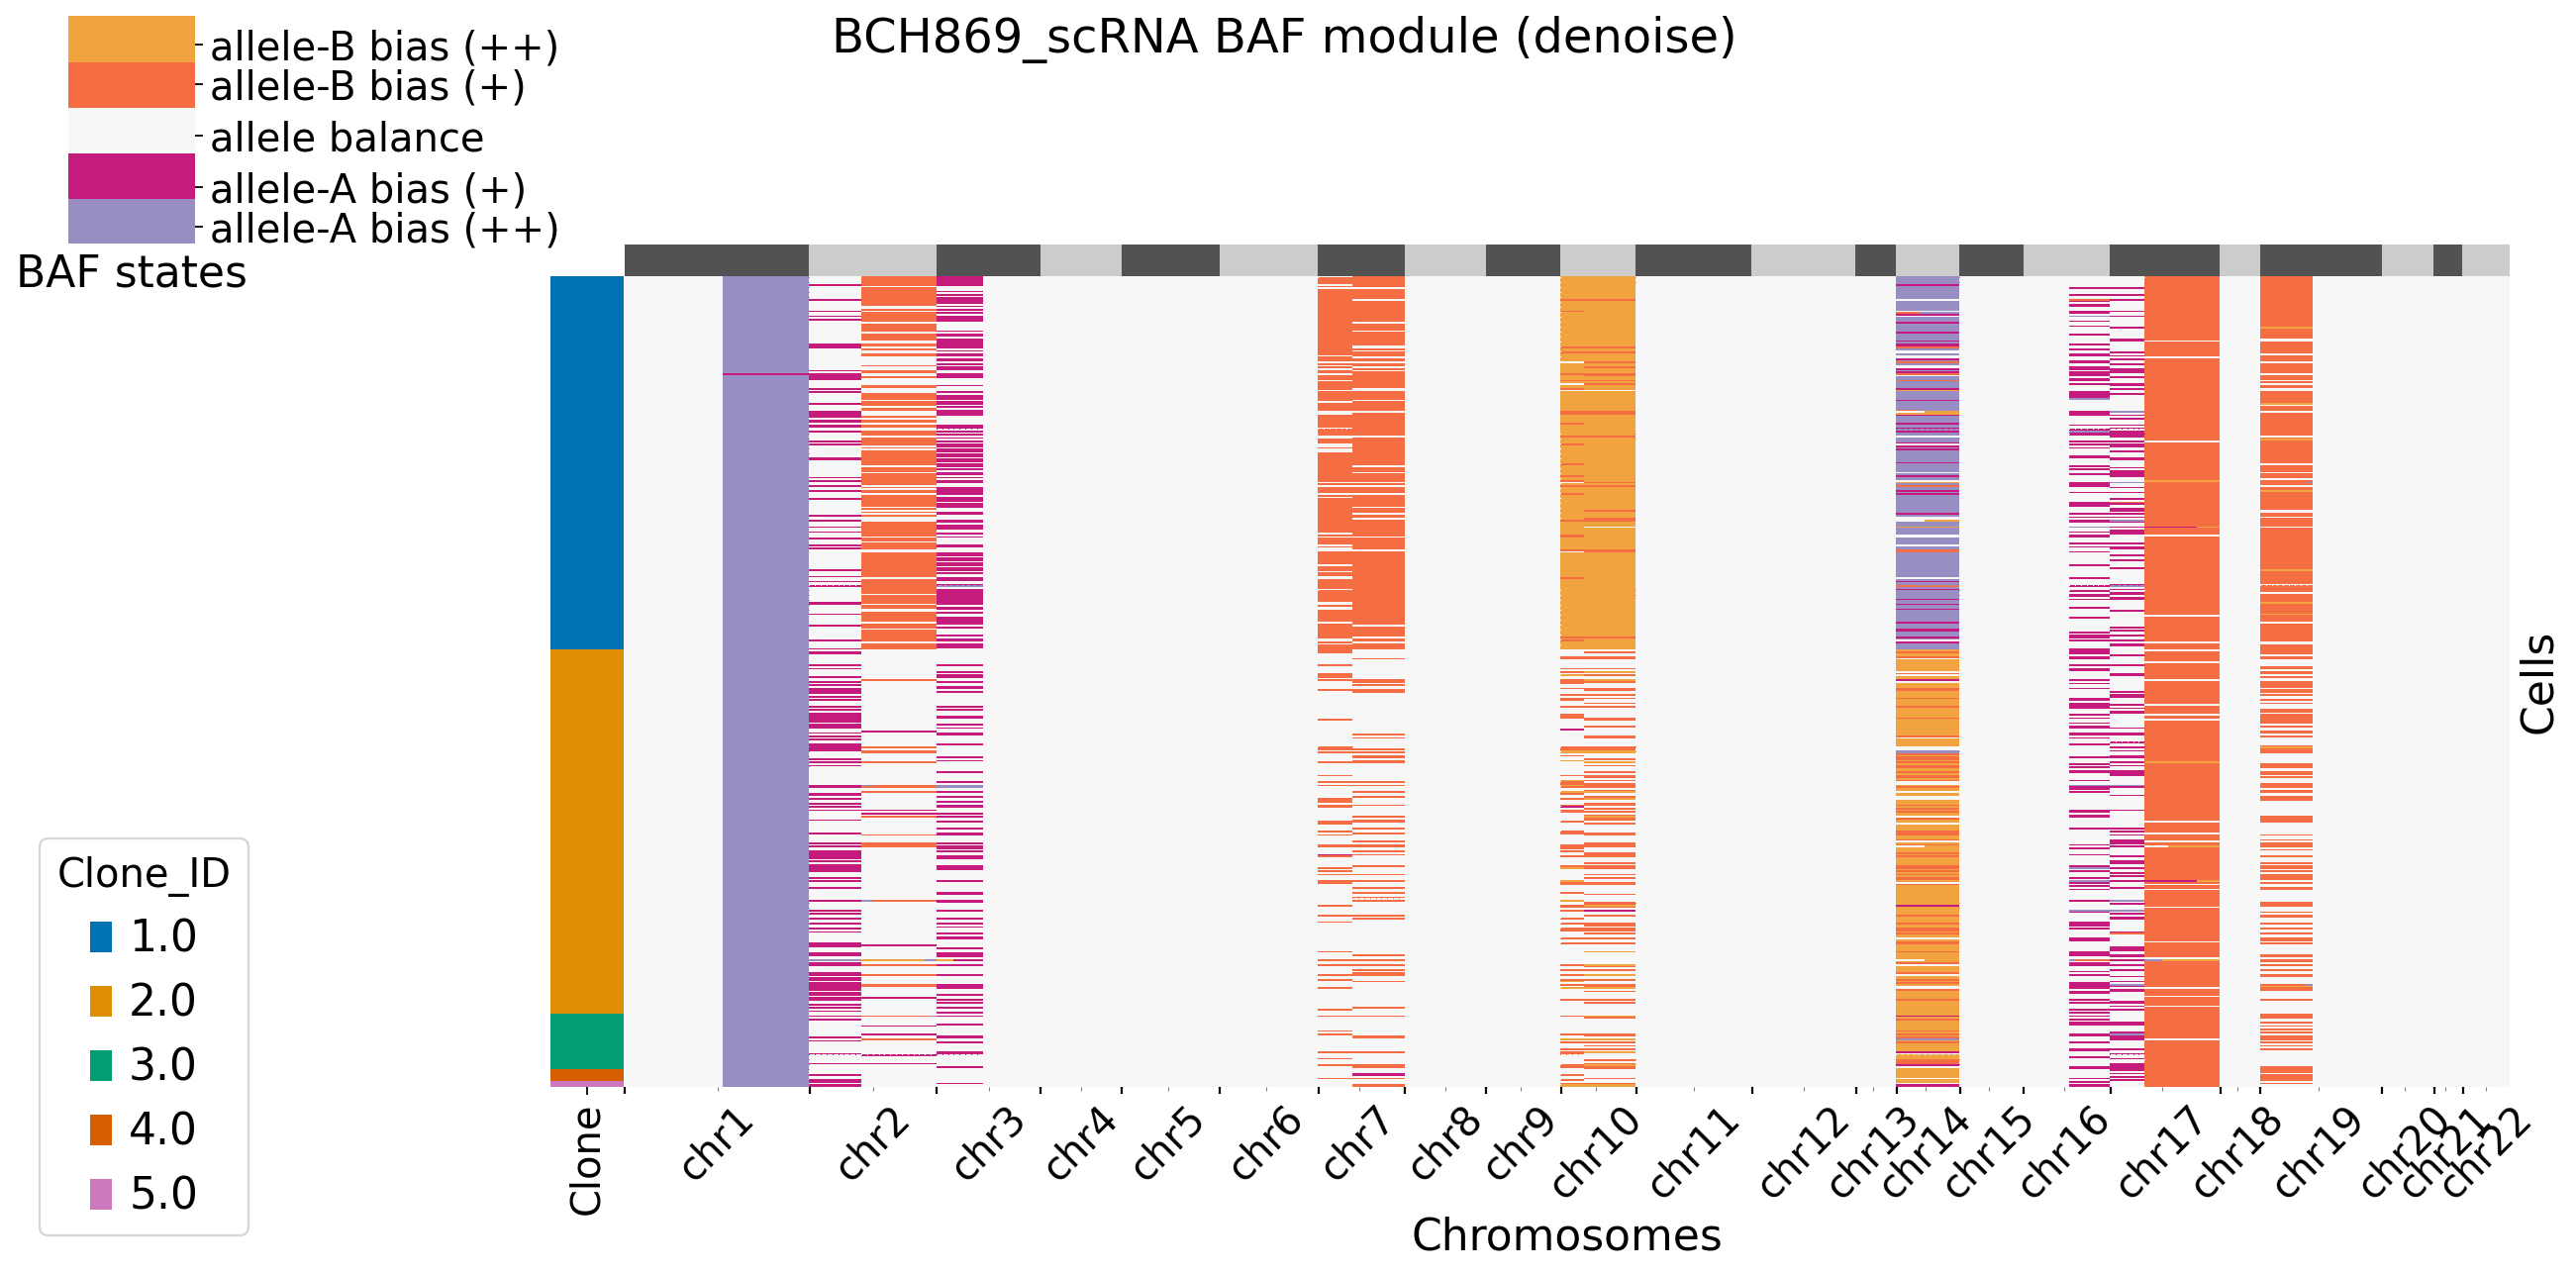

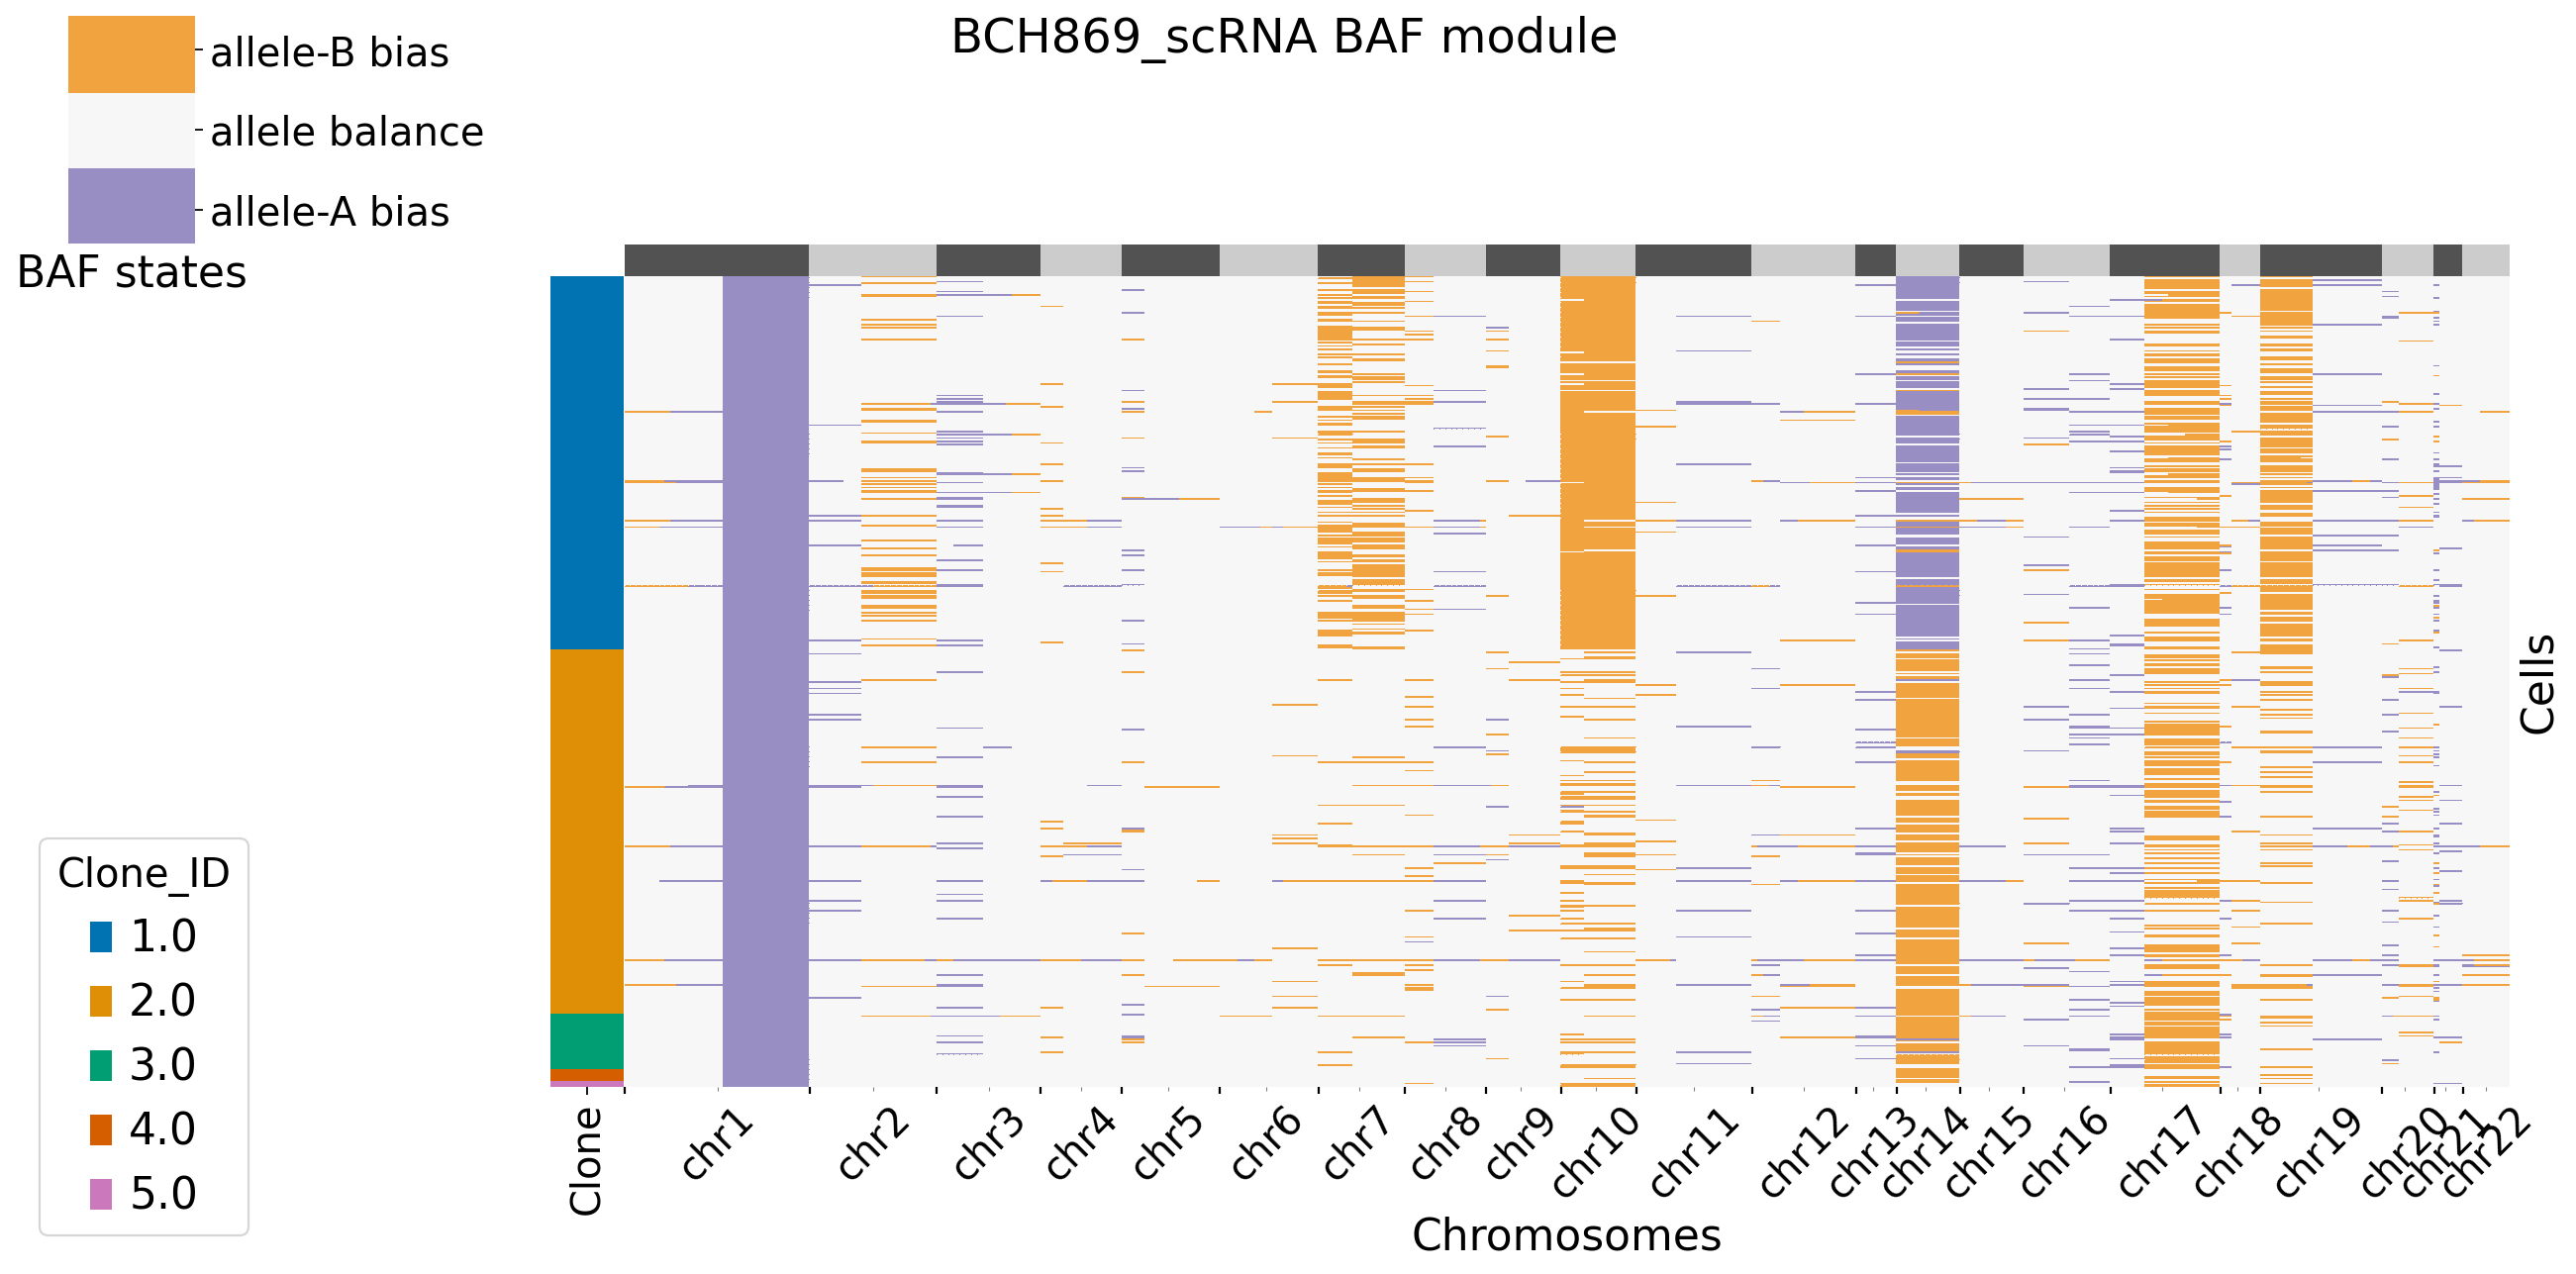

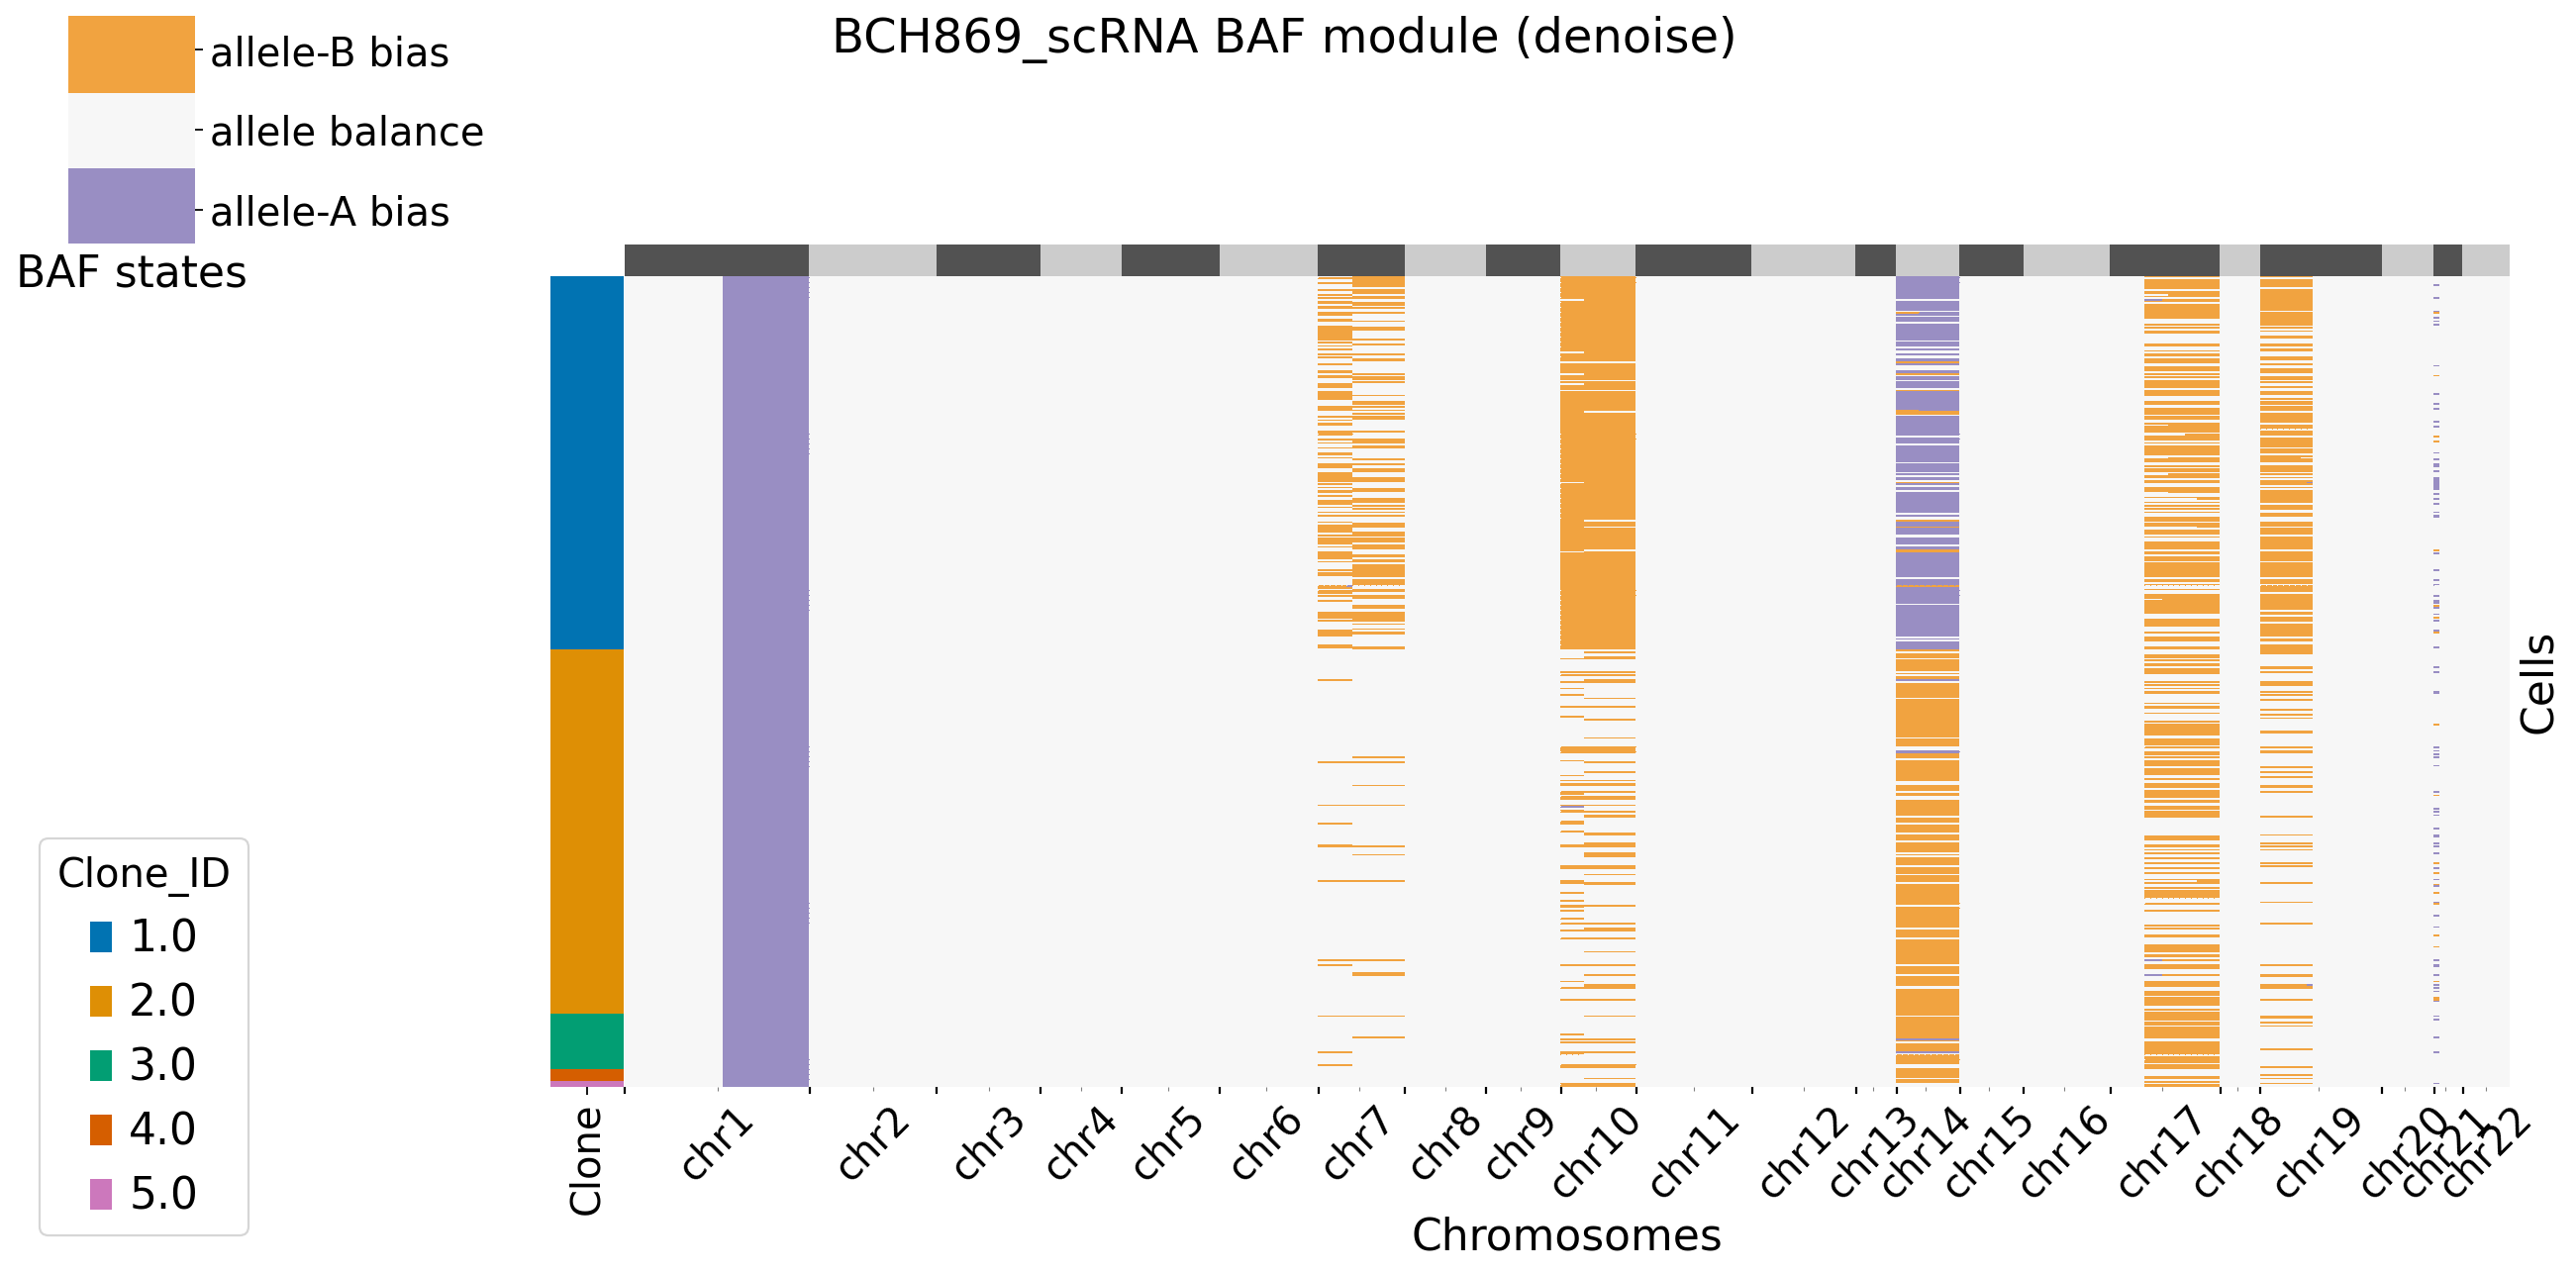

In [11]:
xconfig = xclone.XCloneConfig(dataset_name = dataset_name, module = "BAF", set_smartseq = True, baf_bias_mode = 1)
xconfig.set_figure_params(xclone= True, fontsize = 18)
xconfig.outdir = outdir
xconfig.cell_anno_key = "cell_type"
xconfig.ref_celltype = "N"
xconfig.theo_neutral_BAF = 0.5
xconfig.BAF_denoise = True

xconfig.xclone_plot= True
xconfig.plot_cell_anno_key = "Clone_ID"

xconfig.display()

BAF_merge_Xdata = xclone.model.run_BAF(BAF_adata,
            config_file = xconfig)

In [12]:
BAF_merge_Xdata

AnnData object with n_obs × n_vars = 492 × 326
    obs: 'Sample', 'GenesExpressed', 'HousekeepingGeneExpression', 'Type', 'Cellcycle', 'OPC-variable', 'OC-like', 'AC-like', 'OPC-like', 'Clone_ID', 'cell_type'
    var: 'chr', 'start', 'stop', 'arm', 'chr_arm', 'band', 'gene1_stop', 'bin_stop_arm', 'bin_stop_chr_arm', 'bin_stop_band', 'bin_idx', 'bin_idx_cum', 'GeneName_lst', 'GeneID_lst', 'bin_genes_cnt', 'theo_neutral_BAF', 'concentration'
    uns: 'local_phasing_key', 'local_phasing_len'
    layers: 'ad_bin_softcnt', 'ad_bin', 'dp_bin', 'ad_bin_softcnt_phased', 'ad_bin_phased', 'BAF', 'BAF_phased', 'fill_BAF_phased', 'BAF_phased_KNN', 'BAF_phased_KNN_WMA', 'BAF_phased_WMA', 'bin_phased_BAF_specific_center_emm_prob_log', 'bin_phased_BAF_specific_center_emm_prob_log_KNN', 'emm_prob_log_noHMM', 'emm_prob_noHMM', 'posterior_mtx', 'posterior_mtx_log', 'add_posterior_mtx', 'denoised_add_posterior_mtx', 'denoised_posterior_mtx'
    obsp: 'connectivities_expr'
    varp: 'WMA_connect'

In [13]:
BAF_merge_Xdata.layers["posterior_mtx"].shape

(492, 326, 5)

The final step anndata stored in  `outdir/data/BAF_merge_Xdata_KNN_HMM_post.h5ad` and users can get the CNV indentification in layer `posterior_mtx`.

## Combine module

Similarly, by calling the config method `xclone.XCloneConfig()`, users can create an instance of the `XCloneConfig` class in the `module` of "Combine" to set data-specific configures for Combine module.
It is also default for 10x scRNA-seq data, if the datastet to be analysed is smart-seq, users need set True for `set_smartseq`.

Set the output directory by specifying `outdir`.

Users can decide to plot the main figures in each module or not by setting `xclone_plot`, True or False. If True, can also select cell annotation term `plot_cell_anno_key` for plotting cells by clusters. If `plot_cell_anno_key` is not specified,
default `cell_anno_key= "cell_type"` will be used.

For plotting functions in combine moudle, users can set bool variable `merge_loss` and  `merge_loh` to see if they want to merge allele-specific copy loss/loh states. For more setting in XClone plotting, refer to plotting page.
Here in BCH869 datasets, we keep the allele-specific copy loss states, and we can see clear pattern in chr14.
Users can set `BAF_denoise = True` to combine denoised results from BAF module with RDR module.

Before running the Combine moudle, users can use `xconfig.display()` to print all configurations used in Combine module for previewing and logging.

Users can run the analysis on your input data by calling the `run_combine` method by specifying the `RDR_Xdata`, `BAF_merge_Xdata` and `config_file`. 
If no custmoised config file is used, XClone will load the default config file.

Here shows the example of BCH869 Combine module.

Combine 
Configurations:
BAF_denoise                    True
KNN_neighbors                  10
_file_format_data              h5ad
_file_format_figs              pdf
_frameon                       True
_outdir                        /storage/yhhuang/users/rthuang/xclone/tutorials
_plot_suffix                   
_start                         1680516548.5764465
_vector_friendly               True
cell_anno_key                  cell_type
copygain_correct               False
copygain_correct_mode          None
copyloss_correct               True
copyloss_correct_mode          1
dataset_name                   BCH869_scRNA
exclude_XY                     True
file_format_data               h5ad
file_format_figs               pdf
merge_loh                      True
merge_loss                     False
module                         Combine
outdir                         /storage/yhhuang/users/rthuang/xclone/tutorials
plot_cell_anno_key             Clone_ID
plot_suffix                    
ref_

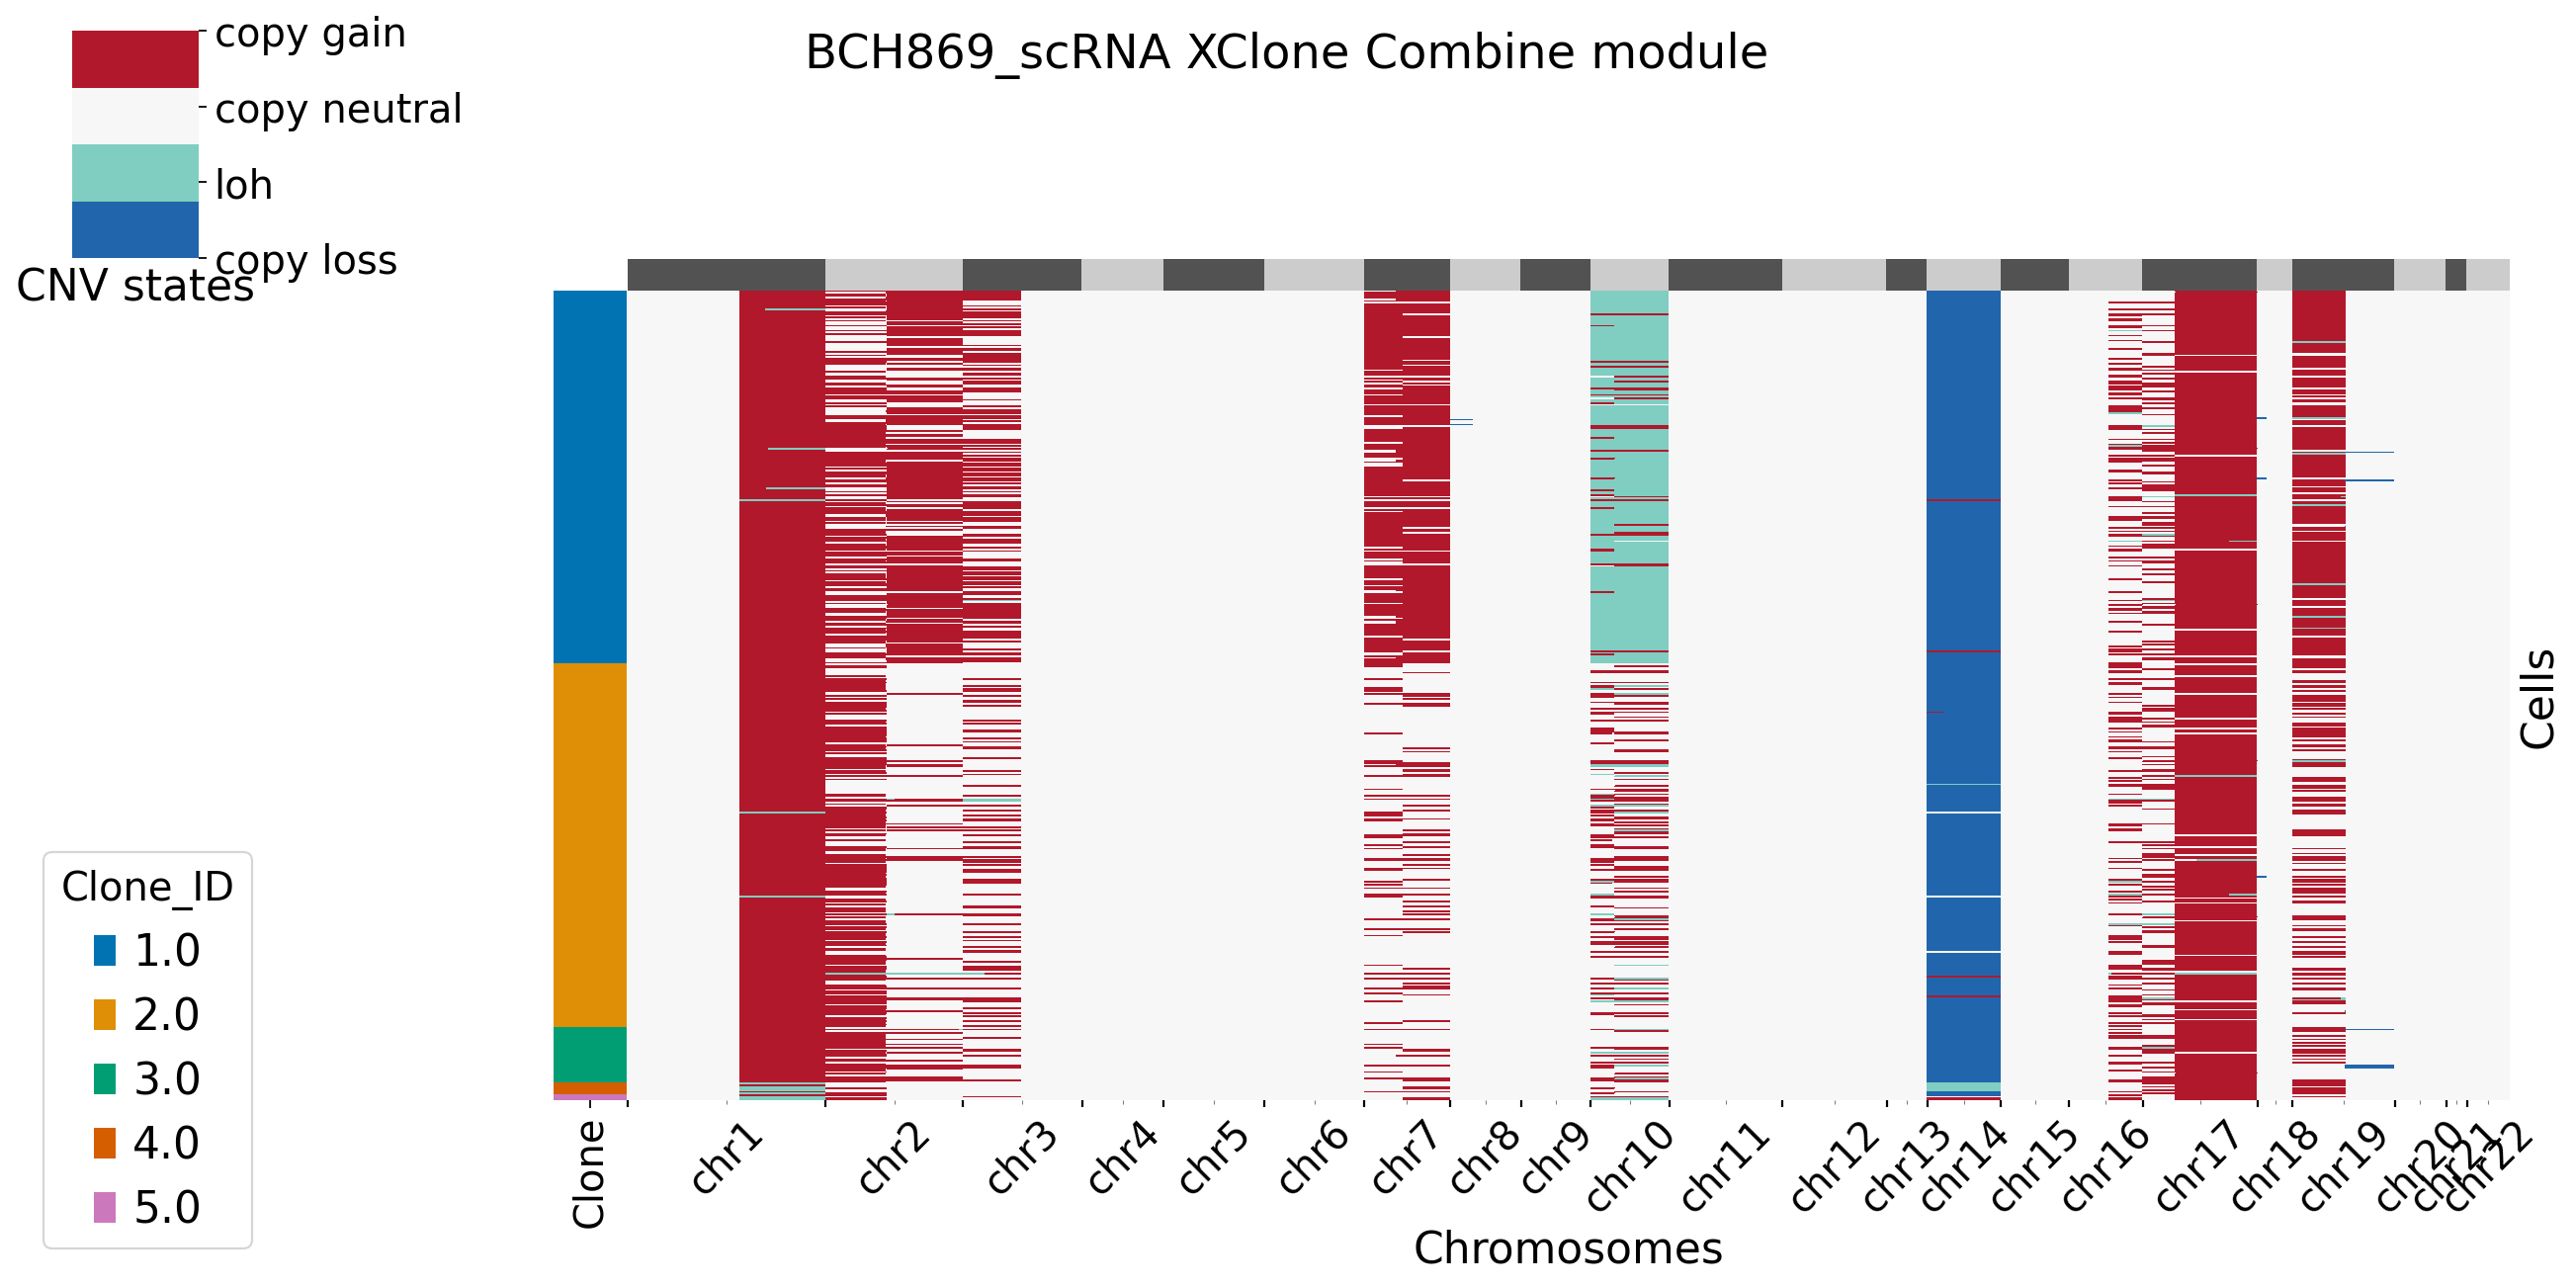

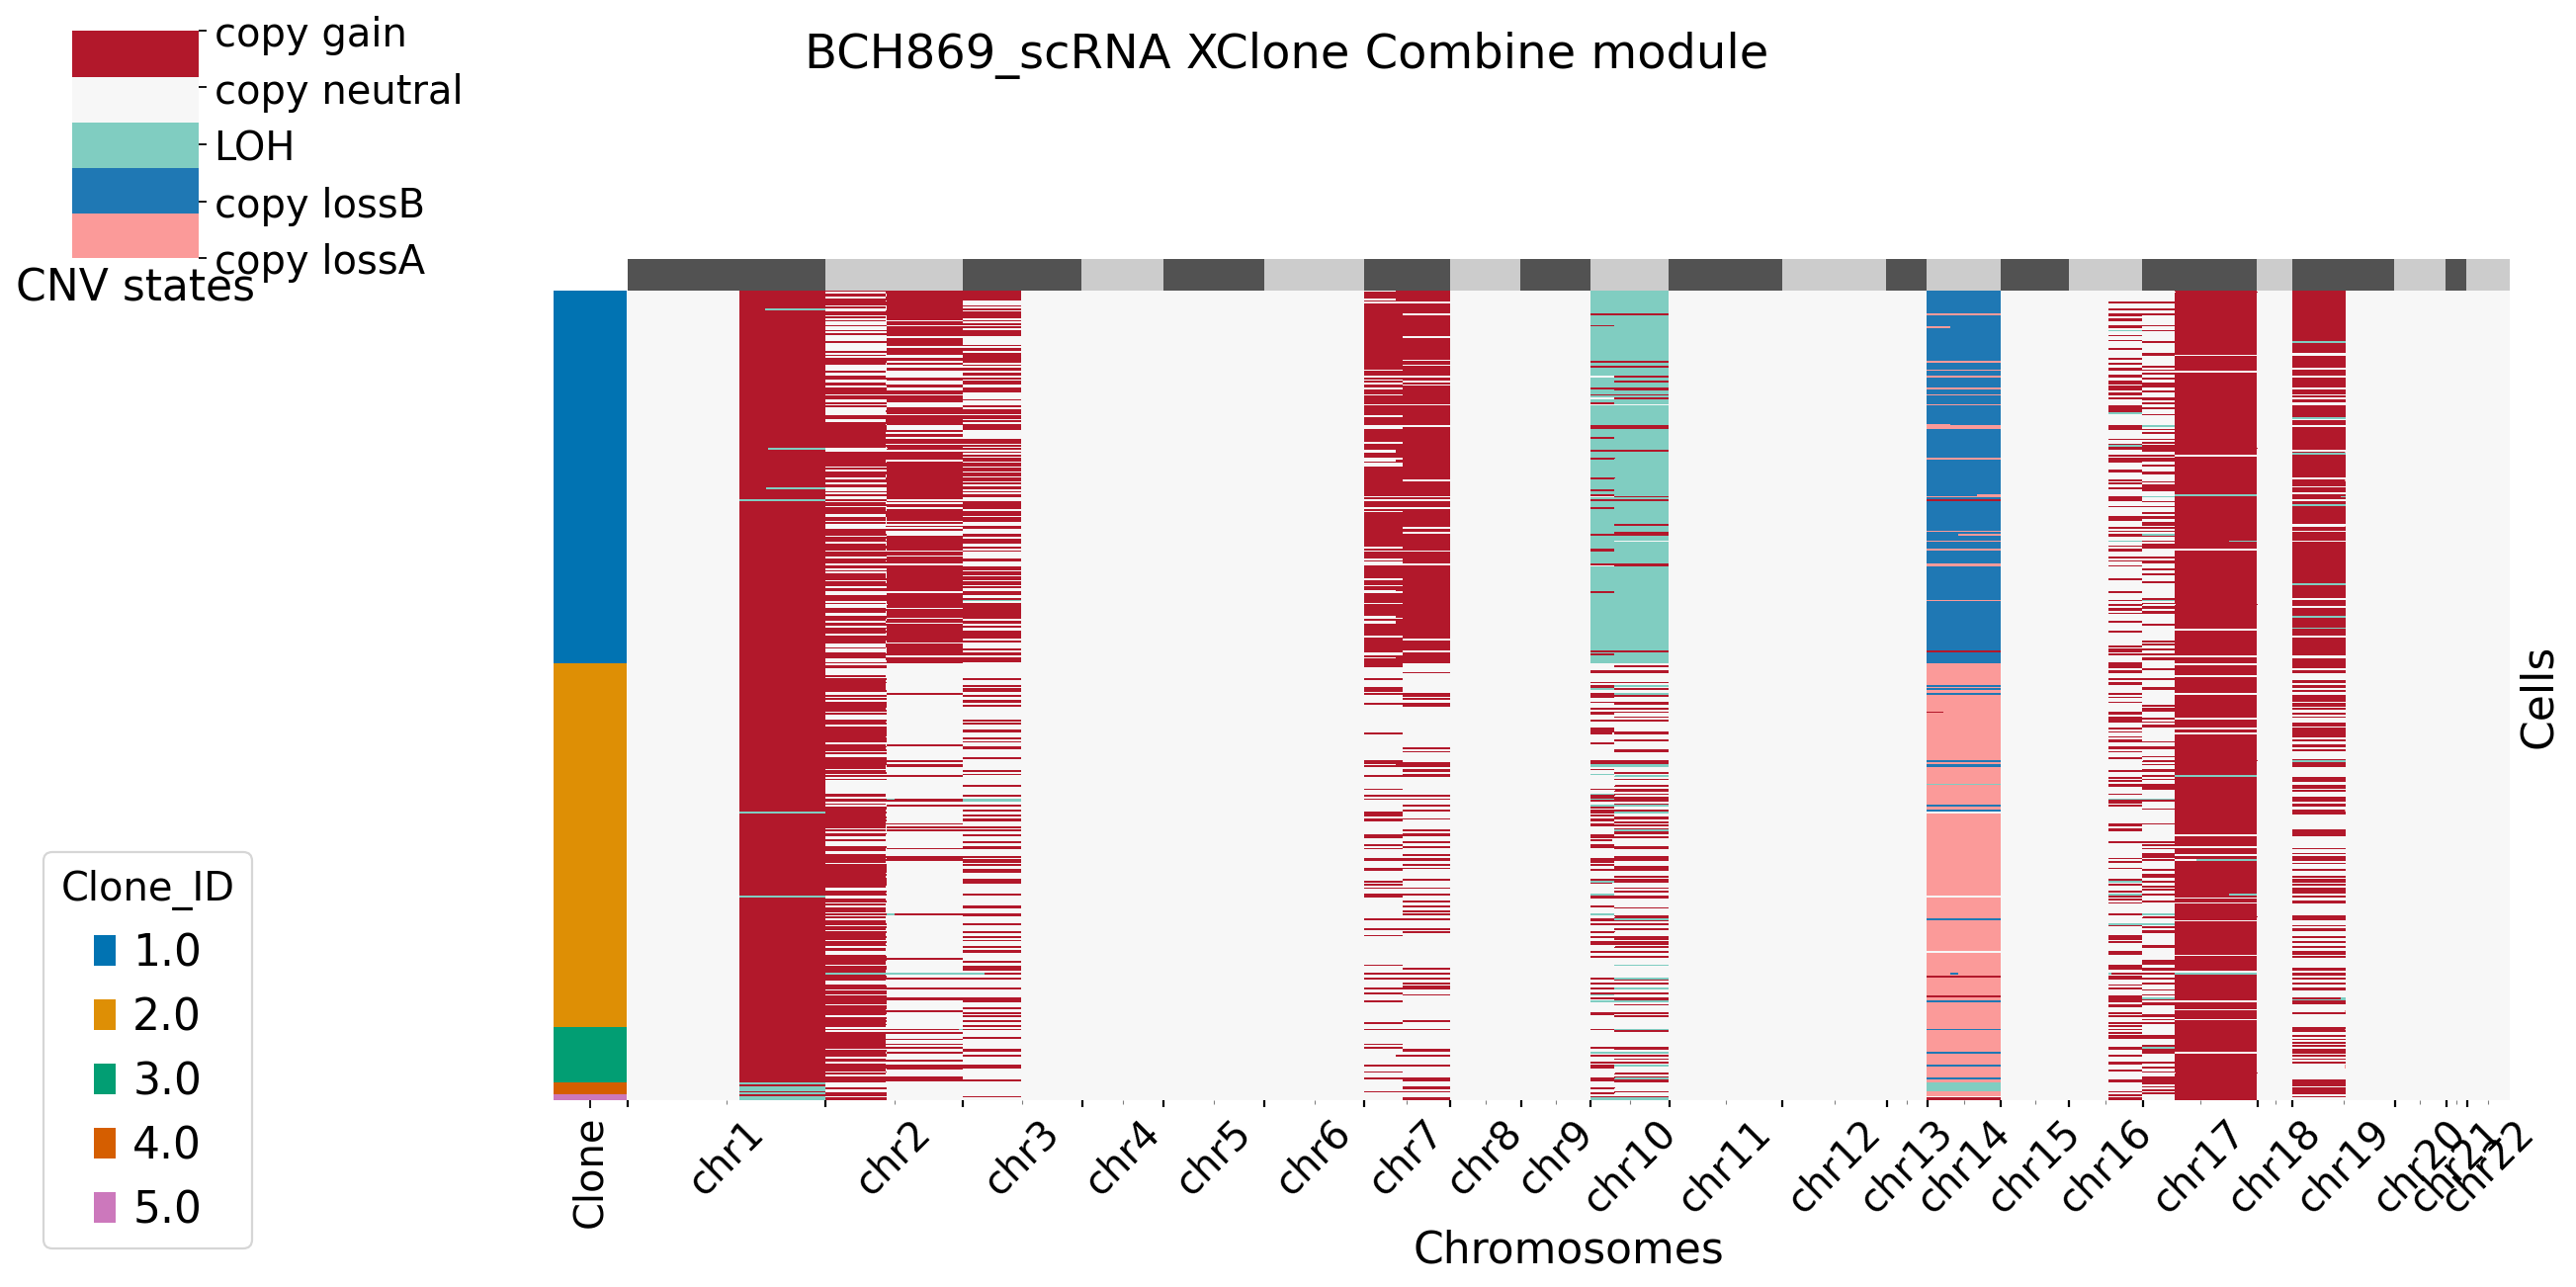

In [14]:
xconfig = xclone.XCloneConfig(dataset_name = dataset_name, module = "Combine", set_smartseq = True)
xconfig.set_figure_params(xclone= True, fontsize = 18)
xconfig.outdir = outdir


xconfig.xclone_plot= True
xconfig.plot_cell_anno_key = "Clone_ID"
xconfig.merge_loss = False
xconfig.merge_loh = True

xconfig.BAF_denoise = True
xconfig.display()

combine_Xdata = xclone.model.run_combine(RDR_Xdata,
                BAF_merge_Xdata,
                verbose = True,
                run_verbose = True,
                config_file = xconfig)

In [15]:
combine_Xdata

AnnData object with n_obs × n_vars = 492 × 5235
    obs: 'Sample', 'GenesExpressed', 'HousekeepingGeneExpression', 'Type', 'Cellcycle', 'OPC-variable', 'OC-like', 'AC-like', 'OPC-like', 'Clone_ID', 'cell_type', 'counts_ratio'
    var: 'GeneName', 'GeneID', 'chr', 'start', 'stop', 'arm', 'chr_arm', 'band', 'ref_avg', 'dispersion', 'gene_dispersion_bse', 'dispersion_capped', 'gene_index'
    uns: 'data_mode', 'data_notes', 'genome_mode', 'log', 'rank_marker_genes', 'fit_dispersion_removed_genes', 'dispersion_base_celltype', 'pca', 'neighbors', 'chr_dict', 'guide_CNV_chrs_use_layers', 'guide_CNV_chrs_use_anno_key', 'ref_log_expression_brk', 'group_genes', 'CNV_ratio', 'Logliklihood'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_expr', 'raw_ratio', 'ref_normalized', 'expected', 'WMA_smoothed', 'RDR_smooth', 'emm_prob_log', 'emm_prob_log_noHMM', 'emm_prob_noHMM', 'posterior_mtx', 'posterior_mtx_log', 'BAF_extend_post_prob', 'combine_base_prob', 'corrected_prob', 'prob1_merge', 'plot_pr

In [16]:
combine_Xdata.layers["corrected_prob"].shape

(492, 5235, 3, 5)

In [17]:
combine_Xdata.layers["prob1_merge"].shape

(492, 5235, 4)

The final step anndata stored in  `outdir/data/combined_final.h5ad` and users can get the CNV indentification in layer `corrected_prob` and `prob1_merge`.